In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sms
import datetime

import statsmodels.api as sm
import xgboost as xgb

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from scipy.stats import pearsonr

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras_tuner import RandomSearch
from keras.optimizers import Adam


In [2]:
df = pd.read_excel("data.xlsx")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4417 entries, 0 to 4416
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date/Time      4417 non-null   datetime64[ns]
 1   Constraint DA  4417 non-null   float64       
 2   Constraint RT  4417 non-null   float64       
 3   Wind           4412 non-null   float64       
 4   Solar          4416 non-null   float64       
 5   AEP Load       4417 non-null   int64         
 6   ATSI Load      4417 non-null   int64         
 7   COMED Load     4417 non-null   int64         
 8   DOM Load       4417 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 310.7 KB


In [4]:
df.isna().sum()

Date/Time        0
Constraint DA    0
Constraint RT    0
Wind             5
Solar            1
AEP Load         0
ATSI Load        0
COMED Load       0
DOM Load         0
dtype: int64

In [5]:
# replace any missing values with the next value. 
# I choose foward fill (ffill) instead of the standard replacement (mean) as it seemed more appropiate for timeseries
df = df.fillna(method='ffill')

In [6]:
df.isna().sum()


Date/Time        0
Constraint DA    0
Constraint RT    0
Wind             0
Solar            0
AEP Load         0
ATSI Load        0
COMED Load       0
DOM Load         0
dtype: int64

In [7]:
# Feature Engineering
df['hour'] = df['Date/Time'].dt.hour
df['day_of_week'] = df['Date/Time'].dt.dayofweek
df["month"] = df["Date/Time"].dt.month_name()

In [8]:
df.head()

Date/Time  Constraint DA  Constraint RT     Wind  Solar  AEP Load  \
0 2021-07-01 01:00:00            0.0            0.0  753.281    0.0     14236   
1 2021-07-01 02:00:00            0.0            0.0  738.755    0.0     13636   
2 2021-07-01 03:00:00            0.0            0.0  724.276    0.0     13171   
3 2021-07-01 04:00:00            0.0            0.0  752.041    0.0     12962   
4 2021-07-01 05:00:00            0.0            0.0  759.611    0.0     13060   

   ATSI Load  COMED Load  DOM Load  hour  day_of_week month  
0       7455       11651     14123     1            3  July  
1       7091       10871     13345     2            3  July  
2       6850       10313     12765     3            3  July  
3       6714        9925     12393     4            3  July  
4       6730        9731     12293     5            3  July

In [9]:
df.describe()

Constraint DA  Constraint RT         Wind        Solar      AEP Load  \
count    4417.000000    4417.000000  4417.000000  4417.000000   4417.000000   
mean      -38.573711     -49.394247  2757.547343   753.184830  14565.183835   
std       115.701292     216.464412  2008.500334   963.148803   2355.529217   
min     -1737.120000   -1920.610000   119.755000     0.000000   9200.000000   
25%         0.000000       0.000000  1123.795000     0.000000  12930.000000   
50%         0.000000       0.000000  2220.221000    22.752000  14203.000000   
75%         0.000000       0.000000  4054.887000  1558.308000  15947.000000   
max         0.000000       0.000000  9110.341000  3138.696000  22122.000000   

          ATSI Load    COMED Load      DOM Load         hour  day_of_week  
count   4417.000000   4417.000000   4417.000000  4417.000000  4417.000000  
mean    7671.254471  11293.011320  12668.480190    11.497849     3.006566  
std     1380.445211   2476.481713   2492.093186     6.923662     1.991195  
min     5201.000000   7346.000000   8425.000000     0.000000     0.000000  
25%     6668.000000   9492.000000  10914.000000     5.000000     1.000000  
50%     7443.000000  10762.000000  12135.000000    11.000000     3.000000  
75%     8345.000000  12353.000000  14010.000000    17.000000     5.000000  
max    12796.000000  20388.000000  20213.000000    23.000000     6.000000

# Data Exploration

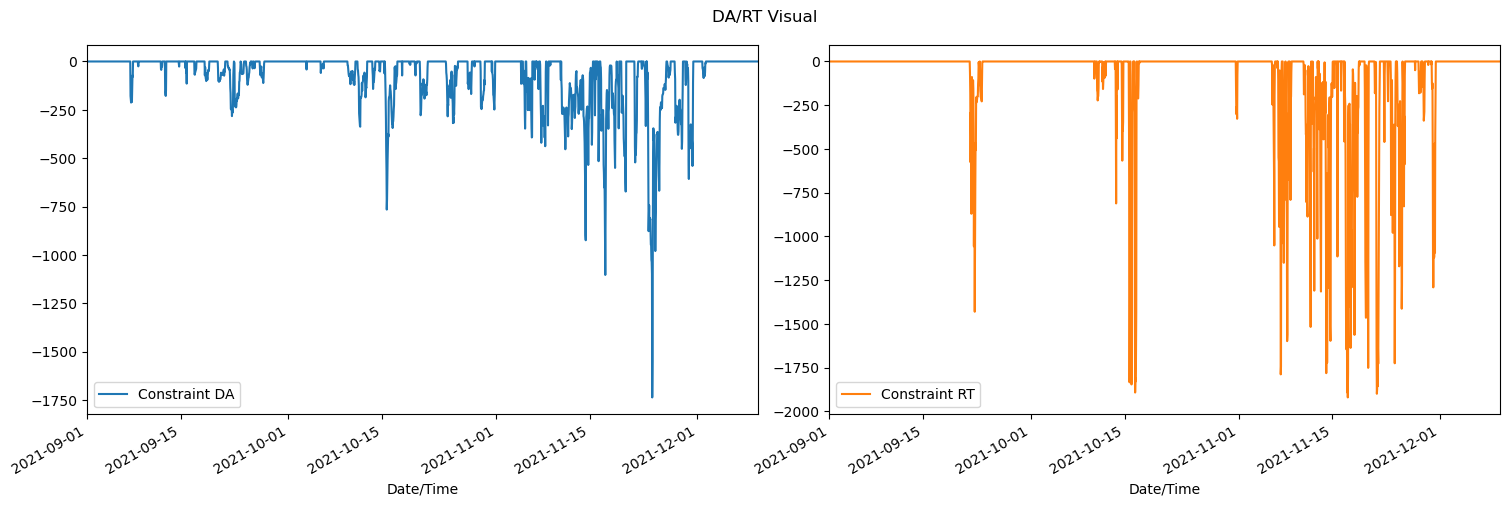

In [10]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

load_cols = ['Constraint DA', 'Constraint RT']

df.set_index('Date/Time')[load_cols].plot(subplots=True, layout=(-1, 2), figsize=(15, 5), title="DA/RT Visual")
plt.tight_layout()

start_date = datetime.datetime(2021, 9, 1)
end_date = datetime.datetime(2021, 12, 10)
plt.xlim([start_date, end_date])

plt.show()


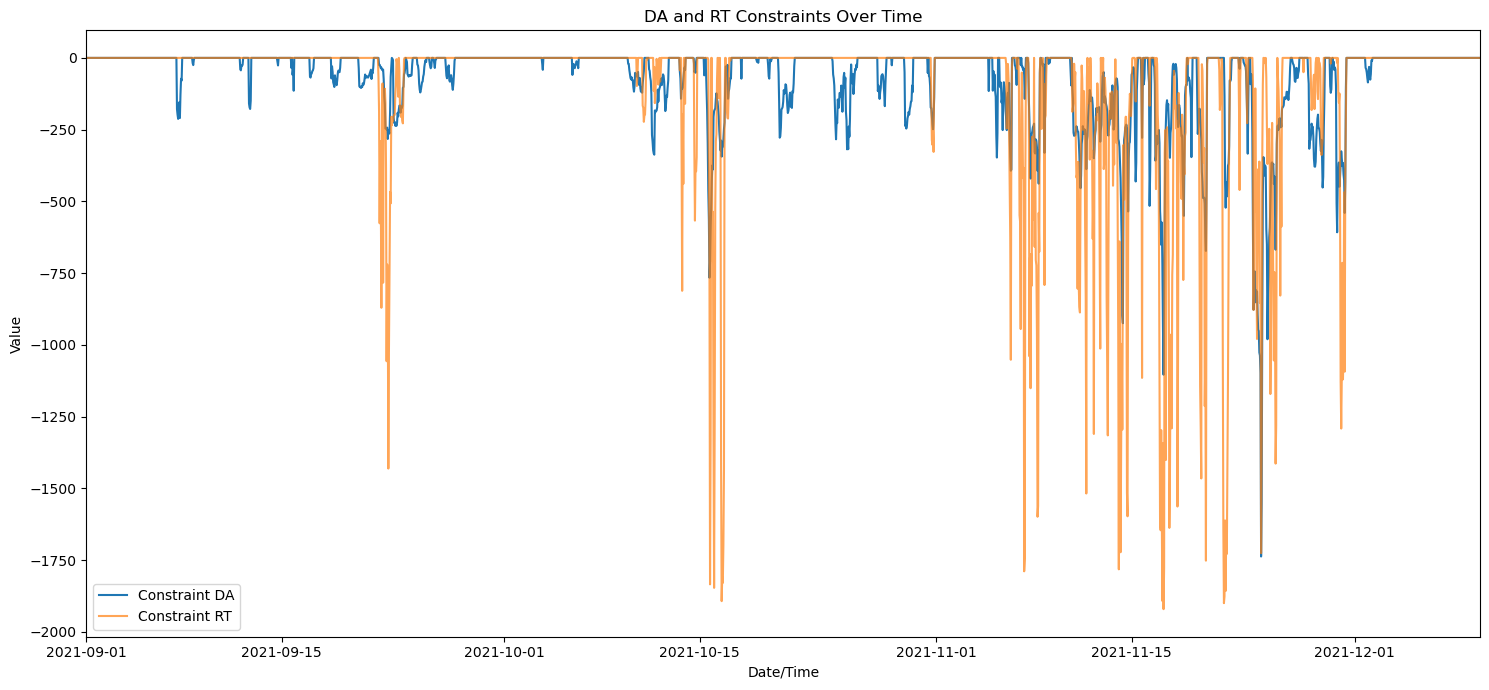

In [11]:
plt.figure(figsize=(15, 7))
plt.plot(df['Date/Time'], df['Constraint DA'], label='Constraint DA')
plt.plot(df['Date/Time'], df['Constraint RT'], label='Constraint RT', alpha=0.7)
plt.title('DA and RT Constraints Over Time')
plt.xlabel('Date/Time')
plt.ylabel('Value')
plt.legend(loc='best')
start_date = datetime.datetime(2021, 9, 1)
end_date = datetime.datetime(2021, 12, 10)
plt.xlim([start_date, end_date])
plt.tight_layout()
plt.show()


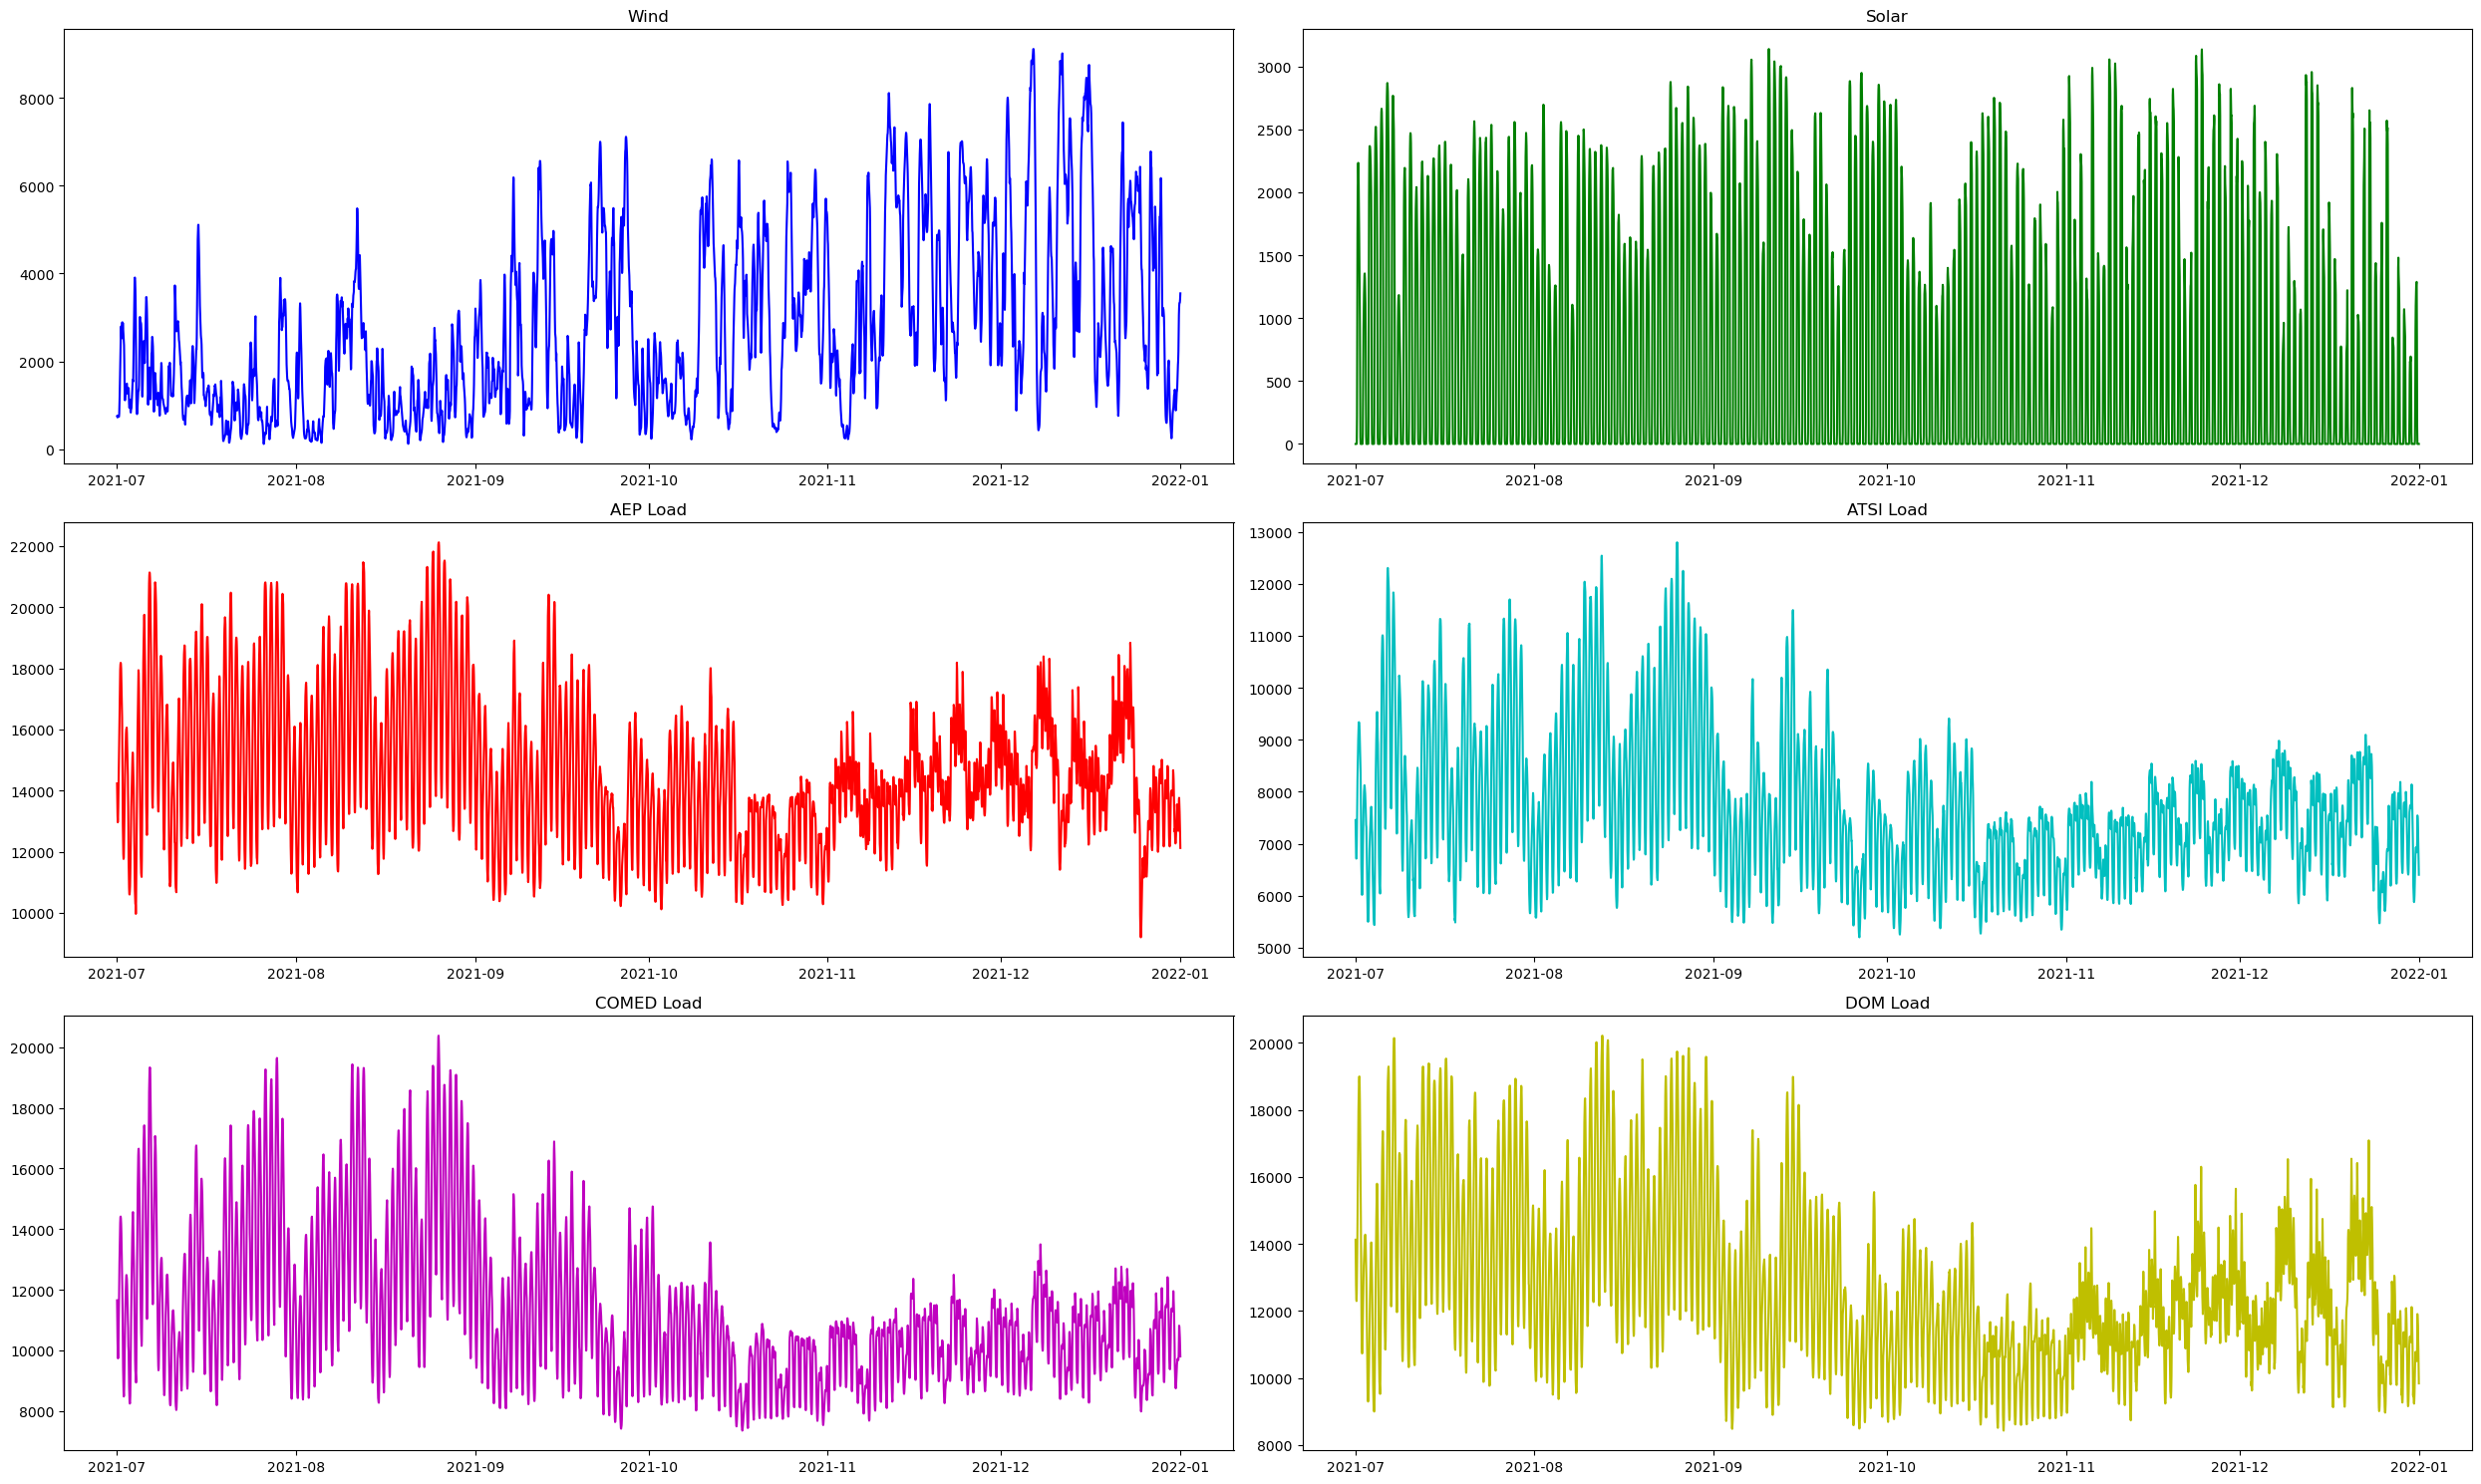

In [12]:
load_cols = ['Wind', 'Solar', 'AEP Load', 'ATSI Load', 'COMED Load', 'DOM Load']
# df.set_index('Date/Time')[load_cols].plot(subplots=True, layout=(-1, 2), figsize=(25, 15))
# plt.tight_layout()
# plt.show()

colors = ['b', 'g', 'r', 'c', 'm', 'y']

fig, axs = plt.subplots(len(load_cols)//2, 2, figsize=(25, 15))  
axs = axs.ravel() 

start_date = datetime.datetime(2021, 7, 1)
end_date = datetime.datetime(2021, 12, 10)

for i, col in enumerate(load_cols):
    axs[i].plot(df['Date/Time'], df[col], color=colors[i % len(colors)])  
    axs[i].set_title(col)  
    #axs[i].set_xlim([start_date, end_date]) 

plt.tight_layout()
plt.show()


## Other Plots

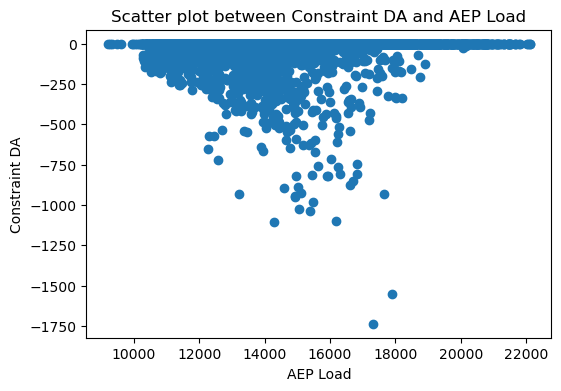

In [13]:
# Create a scatter plot for 'Constraint DA' and 'AEP Load'
plt.figure(figsize=(6, 4))
plt.scatter(df['AEP Load'], df['Constraint DA'])
plt.xlabel('AEP Load')
plt.ylabel('Constraint DA')
plt.title('Scatter plot between Constraint DA and AEP Load')
plt.show()


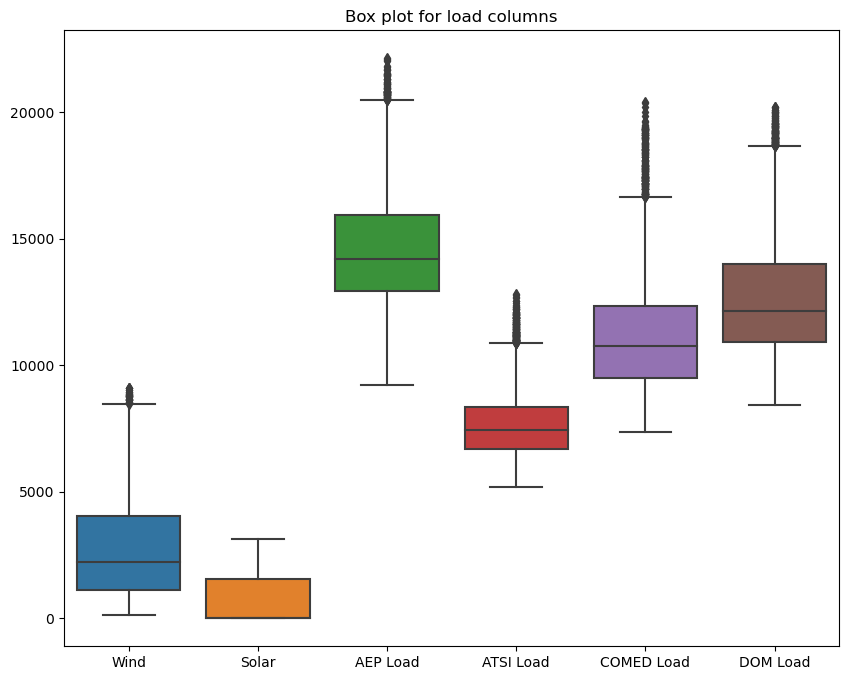

In [14]:
# Boxplot for load columns
plt.figure(figsize=(10, 8))
sms.boxplot(data=df[load_cols])
plt.title('Box plot for load columns')
plt.show()


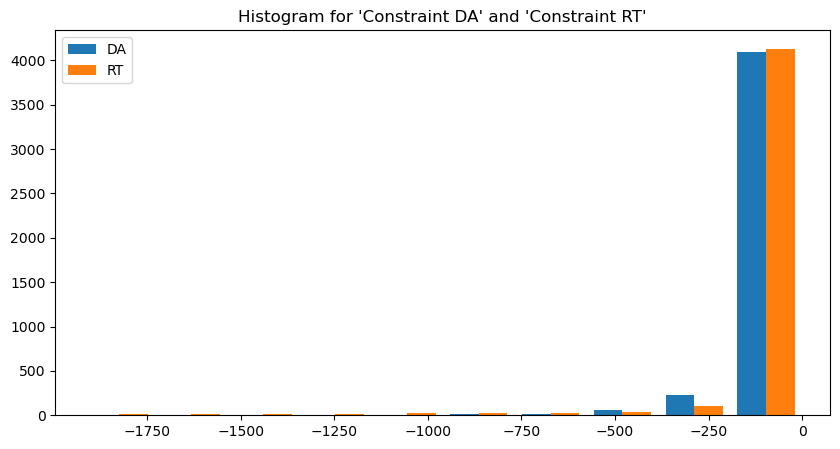

In [15]:
# Histogram for 'Constraint DA' and 'Constraint RT'
plt.figure(figsize=(10, 5))
plt.hist(df[['Constraint DA', 'Constraint RT']])
plt.legend(["DA", "RT"])
plt.title("Histogram for 'Constraint DA' and 'Constraint RT'")
plt.show()


C:\Users\William Hazen\AppData\Local\Temp\ipykernel_26260\517219142.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


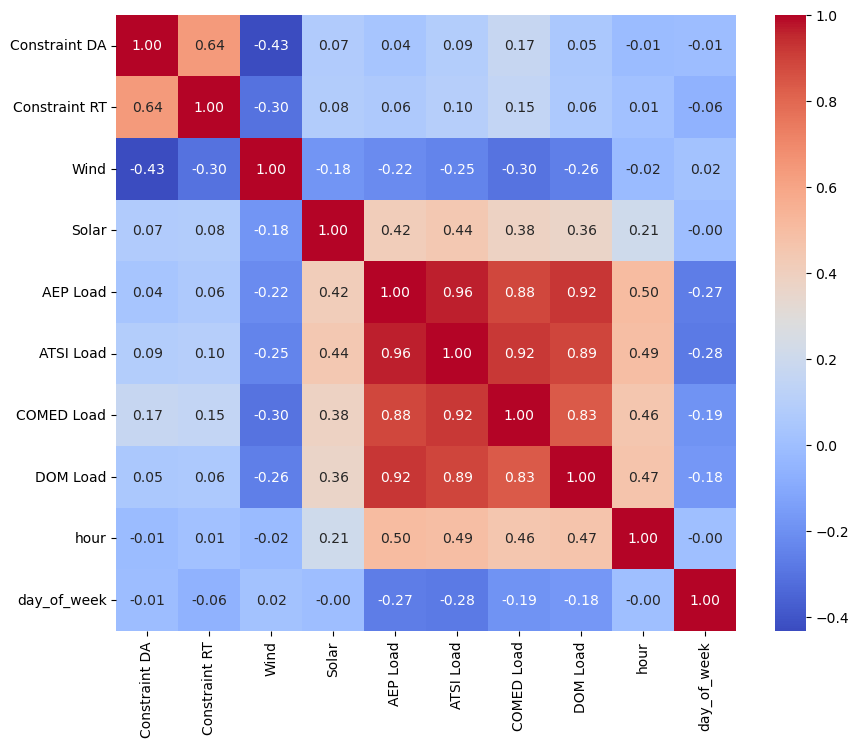

In [16]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sms.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()


## Testing for Stationarity

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
# Ho: It is non stationary
# H1: It is stationary
def adfuller_test(sales):
    result = adfuller(sales)
    labels = ['ADF Test Statistic', 'p-value',
              '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary")


In [19]:
adfuller_test(df['Constraint DA'])


ADF Test Statistic : -6.610039001653793
p-value : 6.411176517556501e-09
#Lags Used : 31
Number of Observations Used : 4385
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [20]:
adfuller_test(df['Constraint RT'])

ADF Test Statistic : -7.707404867001107
p-value : 1.2906000226292755e-11
#Lags Used : 29
Number of Observations Used : 4387
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


- It appears that for both constraints (DA/RT) are stationary timeseries. This indicated that one whose properties do not depend on the time at which the series is observe.

- However, when looking that the plots. DA and RT only show non-zero values between September to December. Not sure the reason for this but it could be related to seasonal relationships - indicating non startionary timeseries

## Differencing 

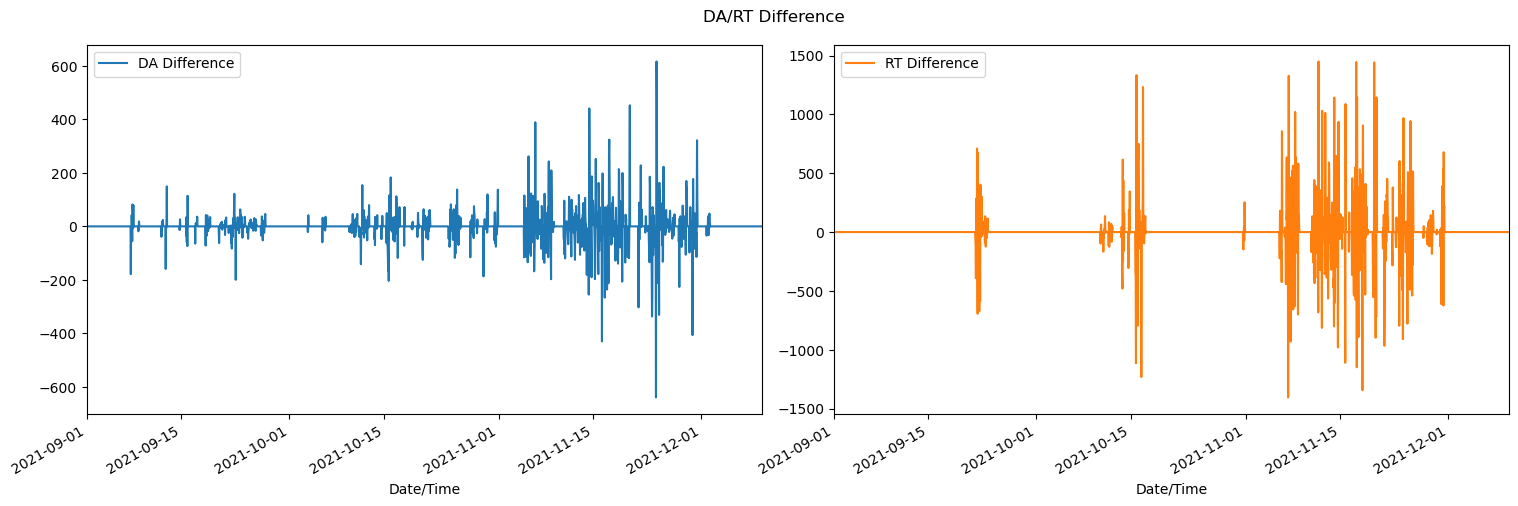

In [21]:
df['DA Difference'] = df['Constraint DA'] - df['Constraint DA'].shift(1)
df['RT Difference'] = df['Constraint RT'] - df['Constraint RT'].shift(1)

load_cols = ['DA Difference', 'RT Difference']

df.set_index('Date/Time')[load_cols].plot(subplots=True,
                                          layout=(-1, 2), figsize=(15, 5), title="DA/RT Difference")
plt.tight_layout()

start_date = datetime.datetime(2021, 9, 1)
end_date = datetime.datetime(2021, 12, 10)
plt.xlim([start_date, end_date])

plt.show()


# Models

## Multivariate LSTM

- I decided to go for a Recurrent Neural Network (RNN) model, in particular a Long Short-Term Memory (LSTM) model. The logic behind choosing an RNN is because RNNs can have variable-sized sequential input, and it selectivley remembers and forgets things over time (improving the overall RNN). LSTM has an internal mechanisms called gates that control the flow of information to and from the memory cell, thereby avoiding the common 'vanishing gradient' problem seen in traditional RNNs. This means that they can model complex dependencies between the current constraints and their previous values, as well as other influential factors like wind or solar power forecasts, can possibly make accurate preditions. Given that the data is a sequential, a LSTM model seemed sutiable as we had a multivariate sequential input data. However there are many different directions I considered, for example another RNN like GRU, which is just a faster version of LSTM but less powerful, or another model being XGBoost. 

- Since the DA and RT constraints are typically influenced by patterns and trends in historical data, I noticed somewhat of a seasonal trend, such that during the holiday season the DA & RT had considerably more activity. However I did not check for weekly seasonality (which I could do in the future), and dependencies on past hours or days. For searching the web, if there a clear cyclical/seasonal effect at play, a timeseries model should work well. Otherwise tabular methods should be fine.

In [22]:
# Create a new instance of the LSTM model to make sure the model is resetting everytime. The model initally had issues resetting.
def lstm_model():
    model = Sequential()
    model.reset_states()
    model.add(LSTM(8, return_sequences=True,input_shape=(X_train.shape[1], 8)))
    model.add(Dense(units=50))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dense(units=50))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dense(units=50))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50))
    model.add(Dense(units=2))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 2:]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :2])
    return np.array(dataX), np.array(dataY)


In [23]:
# Shift data
df['Prev_Day_Constraint_DA'] = df['Constraint DA'].shift(1)
df['Prev_Day_Constraint_RT'] = df['Constraint RT'].shift(1)

df = df.fillna(0)

input_features = df[['Wind', 'Solar', 'AEP Load', 'ATSI Load', 'COMED Load', 'DOM Load', 'Prev_Day_Constraint_DA', 'Prev_Day_Constraint_RT']]
output_features = df[['Constraint DA', 'Constraint RT']]

# Split into train and test sets (70/30 split)
train_size = int(len(df) * 0.7)
test_size = len(df) - train_size

# Train/Test split
input_features_train, input_features_test = input_features.iloc[:train_size], input_features.iloc[train_size:]
output_features_train, output_features_test = output_features.iloc[:train_size], output_features.iloc[train_size:]

input_scaler = MinMaxScaler(feature_range=(0, 1))
output_scaler = MinMaxScaler(feature_range=(0, 1))

scaled_input_train = input_scaler.fit_transform(input_features_train)
scaled_output_train = output_scaler.fit_transform(output_features_train)

scaled_input_test = input_scaler.transform(input_features_test)
scaled_output_test = output_scaler.transform(output_features_test)

train = np.concatenate((scaled_output_train, scaled_input_train), axis=1)
test = np.concatenate((scaled_output_test, scaled_input_test), axis=1)

look_back = 7
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], look_back, X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, X_test.shape[2]))

model = lstm_model()
LSTM_Model = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)


Epoch 1/100
193/193 [==============================] - 9s 12ms/step - loss: 0.0525
Epoch 2/100
193/193 [==============================] - 2s 11ms/step - loss: 0.0049
Epoch 3/100
193/193 [==============================] - 3s 13ms/step - loss: 0.0045
Epoch 4/100
193/193 [==============================] - 3s 13ms/step - loss: 0.0042
Epoch 5/100
193/193 [==============================] - 2s 11ms/step - loss: 0.0040
Epoch 6/100
193/193 [==============================] - 3s 13ms/step - loss: 0.0038
Epoch 7/100
193/193 [==============================] - 2s 13ms/step - loss: 0.0039
Epoch 8/100
193/193 [==============================] - 3s 14ms/step - loss: 0.0037
Epoch 9/100
193/193 [==============================] - 3s 13ms/step - loss: 0.0036
Epoch 10/100
193/193 [==============================] - 3s 16ms/step - loss: 0.0035
Epoch 11/100
193/193 [==============================] - 2s 13ms/step - loss: 0.0034
Epoch 12/100
193/193 [==============================] - 2s 12ms/step - loss: 0.0034
E

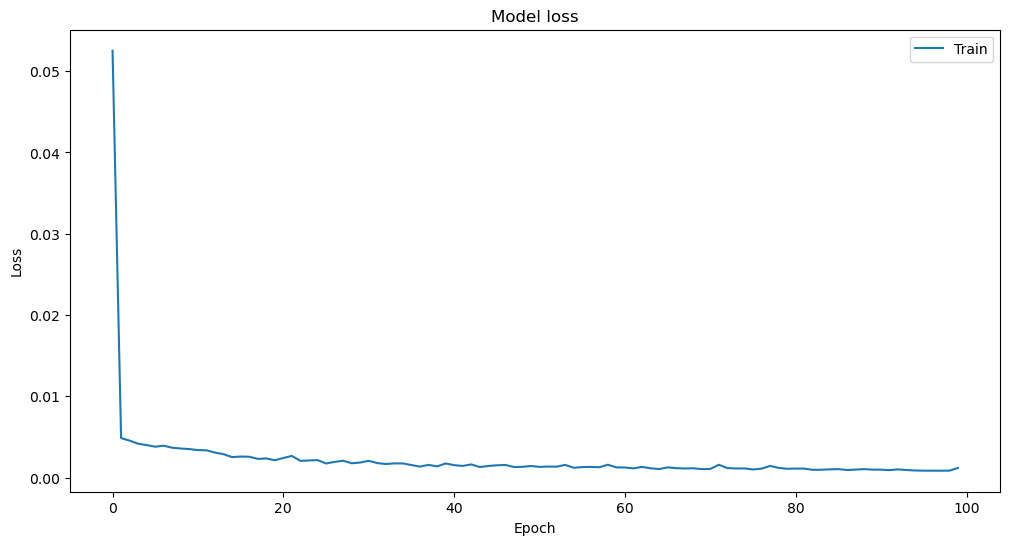

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(LSTM_Model.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [25]:
# Make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

trainPredict = output_scaler.inverse_transform(trainPredict)
y_train = output_scaler.inverse_transform(y_train)
testPredict = output_scaler.inverse_transform(testPredict)
y_test = output_scaler.inverse_transform(y_test)


# For Constraint DA
print("DA")
DA_y_true = y_test[:, 0]
DA_y_pred = testPredict[:, 0]

# RMSE
DA_rmse = np.sqrt(mean_squared_error(DA_y_true, DA_y_pred))
DA_mae = mean_absolute_error(DA_y_true, DA_y_pred)
DA_r2 = r2_score(DA_y_true, DA_y_pred)
DA_dir_acc = np.mean(np.sign(DA_y_true[1:] - DA_y_true[:-1]) == np.sign(DA_y_pred[1:] - DA_y_pred[:-1]))

print(f'Root Mean Squared Error: {DA_rmse}')
print(f'Mean Absolute Error: {DA_mae}')
print(f'R2 Score: {DA_r2}')
print(f'Direction Accuracy: {DA_dir_acc}')

print("---------------------------------------------")

# For Constraint RT
print("RT")
RT_y_true = y_test[:, 1]
RT_y_pred = testPredict[:, 1]

RT_rmse = np.sqrt(mean_squared_error(RT_y_true, RT_y_pred))
RT_mae = mean_absolute_error(RT_y_true, RT_y_pred)
RT_r2 = r2_score(RT_y_true, RT_y_pred)
RT_dir_acc = np.mean(np.sign(RT_y_true[1:] - RT_y_true[:-1]) == np.sign(RT_y_pred[1:] - RT_y_pred[:-1]))

print(f'Root Mean Squared Error: {RT_rmse}')
print(f'Mean Absolute Error: {RT_mae}')
print(f'R2 Score: {RT_r2}')
print(f'Direction Accuracy: {RT_dir_acc}')

42/42 [==============================] - 0s 6ms/step
DA
Root Mean Squared Error: 125.9793168481325
Mean Absolute Error: 66.47423451150819
R2 Score: 0.5283678064247228
Direction Accuracy: 0.170083523158694
---------------------------------------------
RT
Root Mean Squared Error: 347.9070863535289
Mean Absolute Error: 140.90333871454675
R2 Score: -0.06597803257106682
Direction Accuracy: 0.12832194381169323


In [26]:
look_back = 7

predictions = trainPredict
prediction_df = pd.DataFrame(predictions, columns=['Predicted DA', 'Predicted RT'])

date_time = df['Date/Time']
test_size = int(len(df) * 0.3)

total_look_back = (look_back-3) * 2  +1
adjusted_df_index = date_time[test_size + total_look_back:]

prediction_df = prediction_df.set_index(adjusted_df_index)
prediction_df


Predicted DA  Predicted RT
Date/Time                                      
2021-08-25 15:00:00      1.115858     -0.136387
2021-08-25 16:00:00      1.292325     -0.032602
2021-08-25 17:00:00      1.384621      0.001805
2021-08-25 18:00:00      1.402240     -0.005076
2021-08-25 19:00:00      1.363989     -0.002482
...                           ...           ...
2021-12-31 20:00:00    -14.873923    -18.022209
2021-12-31 21:00:00     -6.888641    -10.233685
2021-12-31 22:00:00     -3.540747     -4.332022
2021-12-31 23:00:00     -2.032381     -1.285133
2022-01-01 00:00:00     -2.303563     -0.857808

[3083 rows x 2 columns]

### Predictions

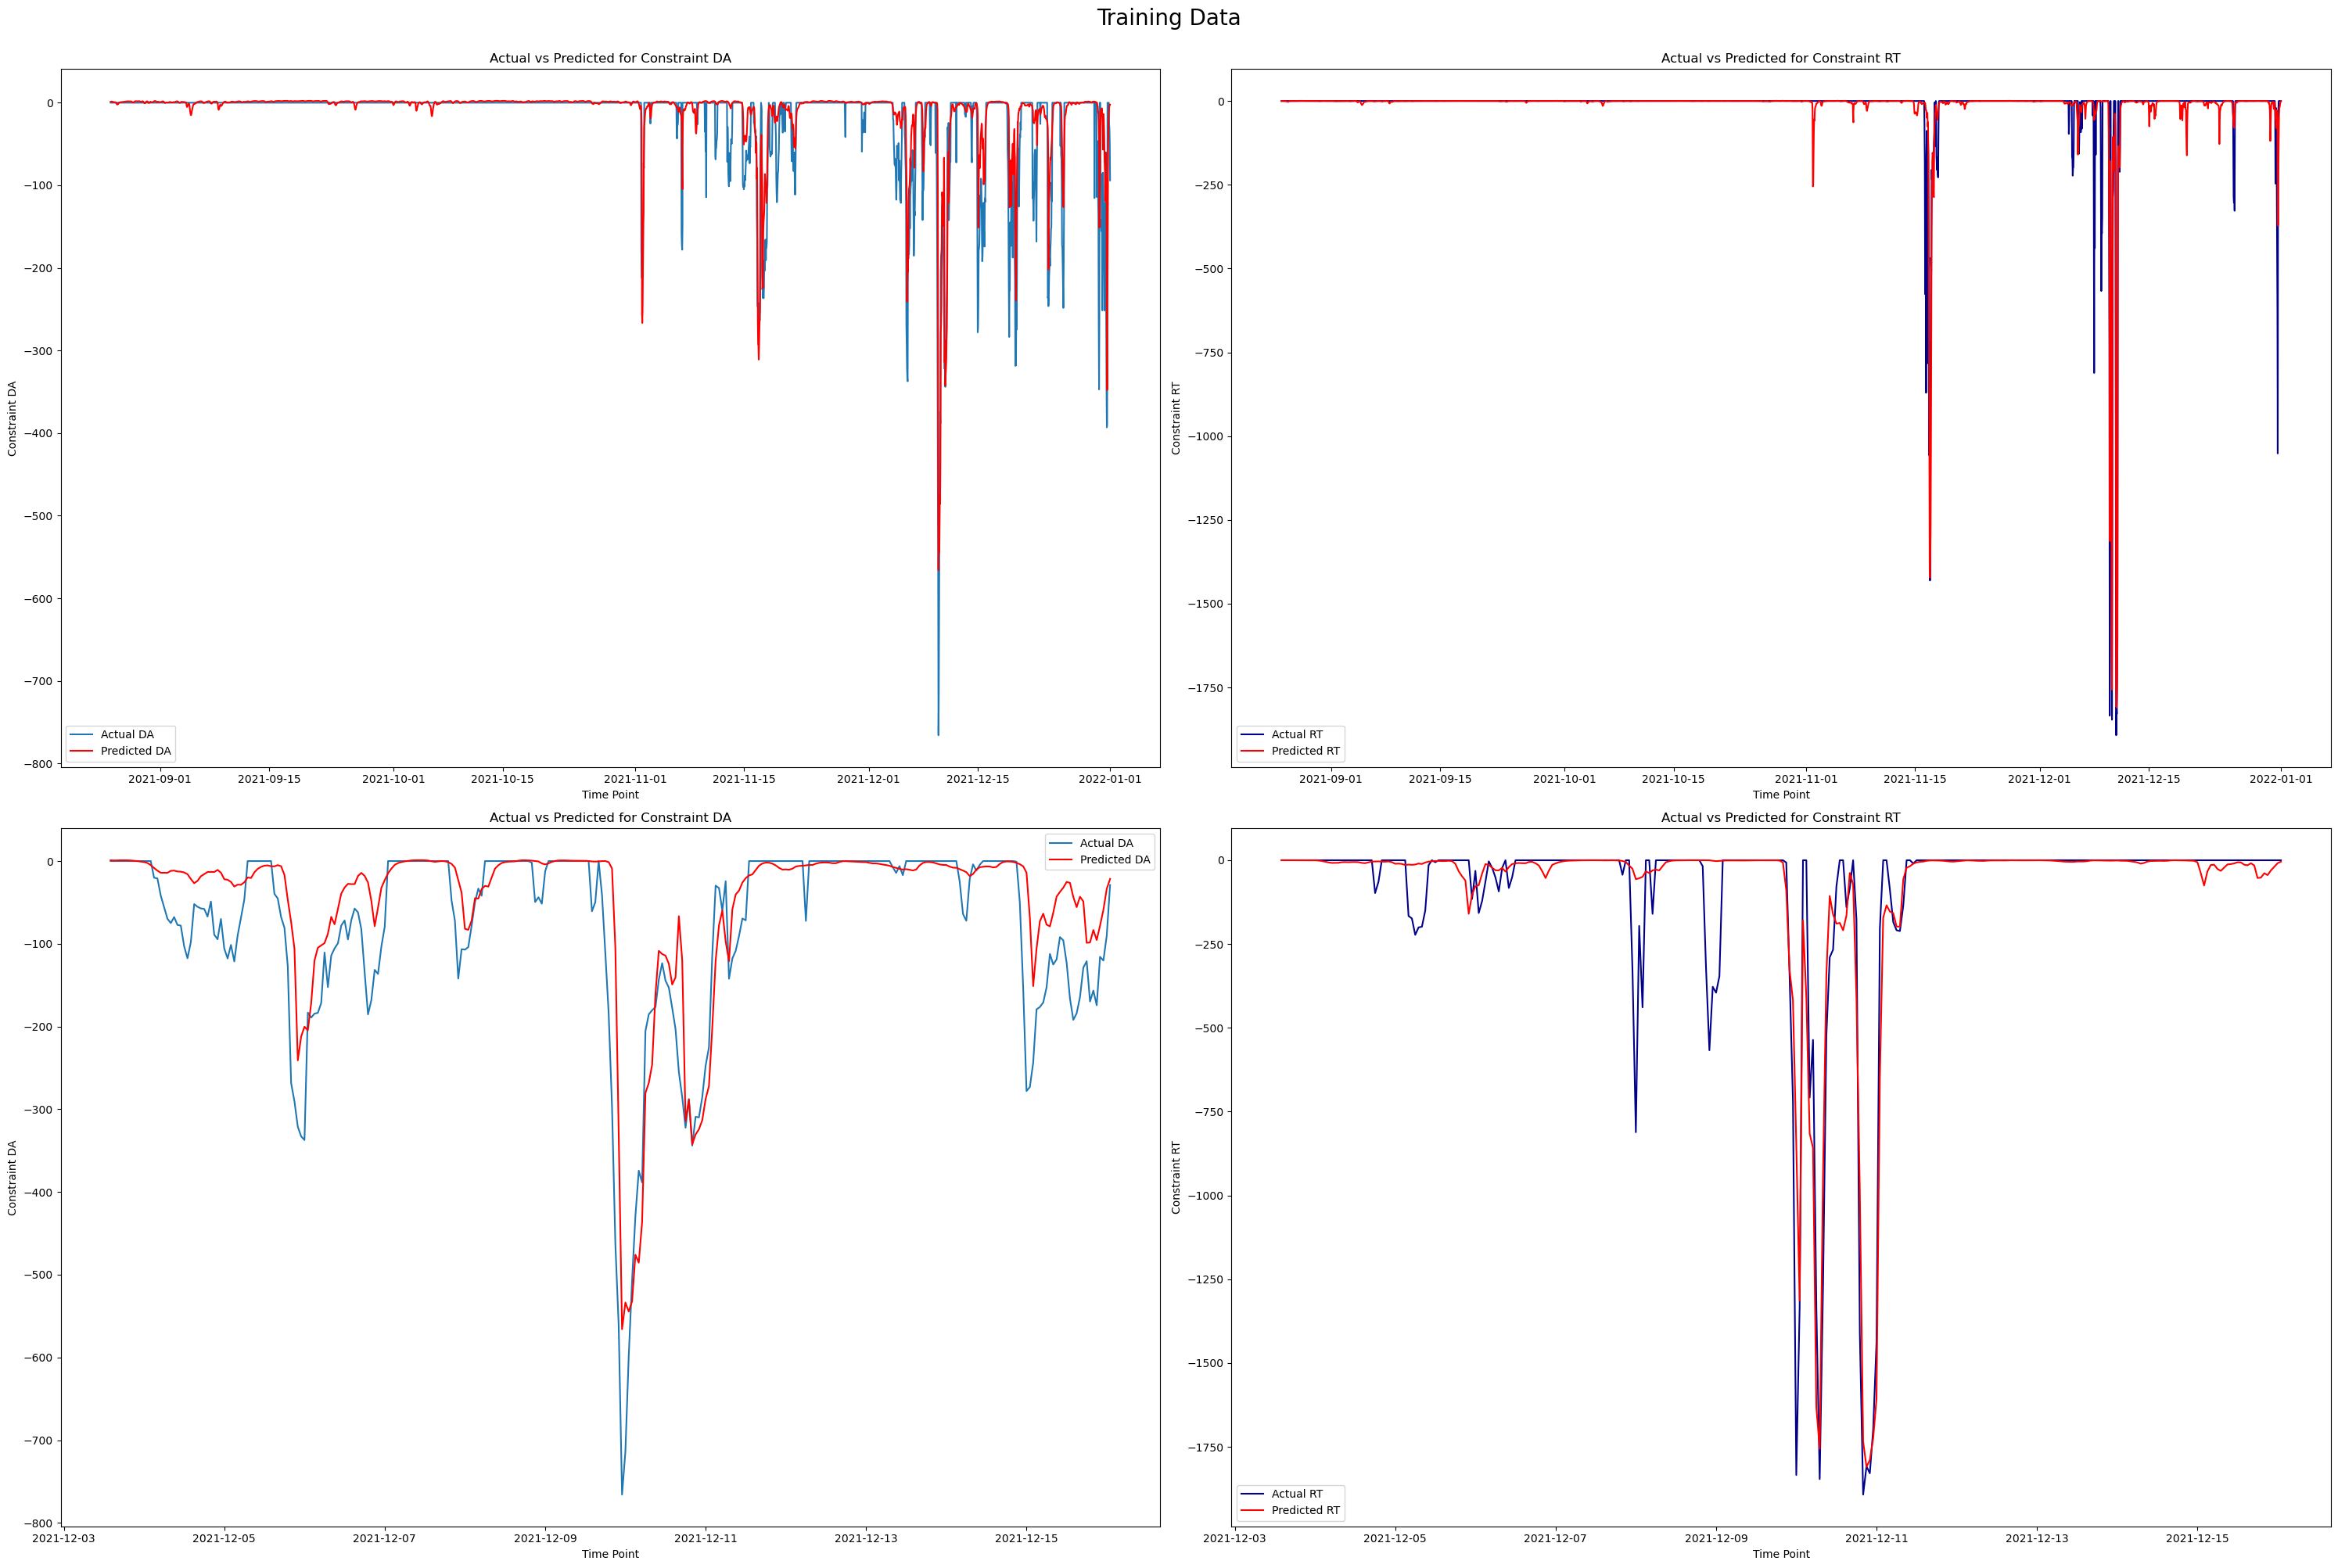

In [27]:
time_point = prediction_df.index.tolist()

start_index = 2400  # Adjust this to change the starting index of the plot
end_index = 2700  # Adjust this to change the ending index of the plot

fig, axs = plt.subplots(2, 2, figsize=(30, 20))

# Plot 1: Actual vs Predicted for Constraint DA (full range)
axs[0, 0].plot(time_point, y_train[:, 0], label='Actual DA')
axs[0, 0].plot(time_point, trainPredict[:, 0], label='Predicted DA', color='red')
axs[0, 0].set_title('Actual vs Predicted for Constraint DA')
axs[0, 0].set_xlabel('Time Point')
axs[0, 0].set_ylabel('Constraint DA')
axs[0, 0].legend()

# Plot 2: Actual vs Predicted for Constraint RT (full range)
axs[0, 1].plot(time_point, y_train[:, 1], label='Actual RT', color = 'darkblue')
axs[0, 1].plot(time_point, trainPredict[:, 1], label='Predicted RT', color='red')
axs[0, 1].set_title('Actual vs Predicted for Constraint RT')
axs[0, 1].set_xlabel('Time Point')
axs[0, 1].set_ylabel('Constraint RT')
axs[0, 1].legend()

# Plot 3: Actual vs Predicted for Constraint DA 
axs[1, 0].plot(time_point[start_index:end_index], y_train[start_index:end_index, 0], label='Actual DA')
axs[1, 0].plot(time_point[start_index:end_index], trainPredict[start_index:end_index, 0], label='Predicted DA', color='red')
axs[1, 0].set_title('Actual vs Predicted for Constraint DA')
axs[1, 0].set_xlabel('Time Point')
axs[1, 0].set_ylabel('Constraint DA')
axs[1, 0].legend()

# Plot 4: Actual vs Predicted for Constraint RT
axs[1, 1].plot(time_point[start_index:end_index], y_train[start_index:end_index, 1], label='Actual RT', color="darkblue")
axs[1, 1].plot(time_point[start_index:end_index], trainPredict[start_index:end_index, 1], label='Predicted RT', color='red')
axs[1, 1].set_title('Actual vs Predicted for Constraint RT')
axs[1, 1].set_xlabel('Time Point')
axs[1, 1].set_ylabel('Constraint RT')
axs[1, 1].legend()

fig.suptitle('Training Data', fontsize=20, y=1)
plt.tight_layout()
plt.show()

In [28]:
look_back = 7

predictions = testPredict
prediction_df = pd.DataFrame(
    predictions, columns=['Predicted DA', 'Predicted RT'])

date_time = df['Date/Time']
train_size = int(len(df) * 0.7)

total_look_back = (look_back-3) * 2
adjusted_df_index = date_time[train_size + total_look_back:]

prediction_df = prediction_df.set_index(adjusted_df_index)
prediction_df


Predicted DA  Predicted RT
Date/Time                                      
2021-11-07 03:00:00    -22.173147    -16.695223
2021-11-07 04:00:00    -12.920647     -9.102311
2021-11-07 05:00:00     -9.199872     -6.092198
2021-11-07 06:00:00     -9.389804     -6.586307
2021-11-07 07:00:00    -10.582347     -7.630252
...                           ...           ...
2021-12-31 20:00:00     -3.529427     -1.165442
2021-12-31 21:00:00     -2.964834     -0.783241
2021-12-31 22:00:00     -2.398552     -0.671559
2021-12-31 23:00:00     -2.140516     -0.779518
2022-01-01 00:00:00     -2.067163     -0.950087

[1318 rows x 2 columns]

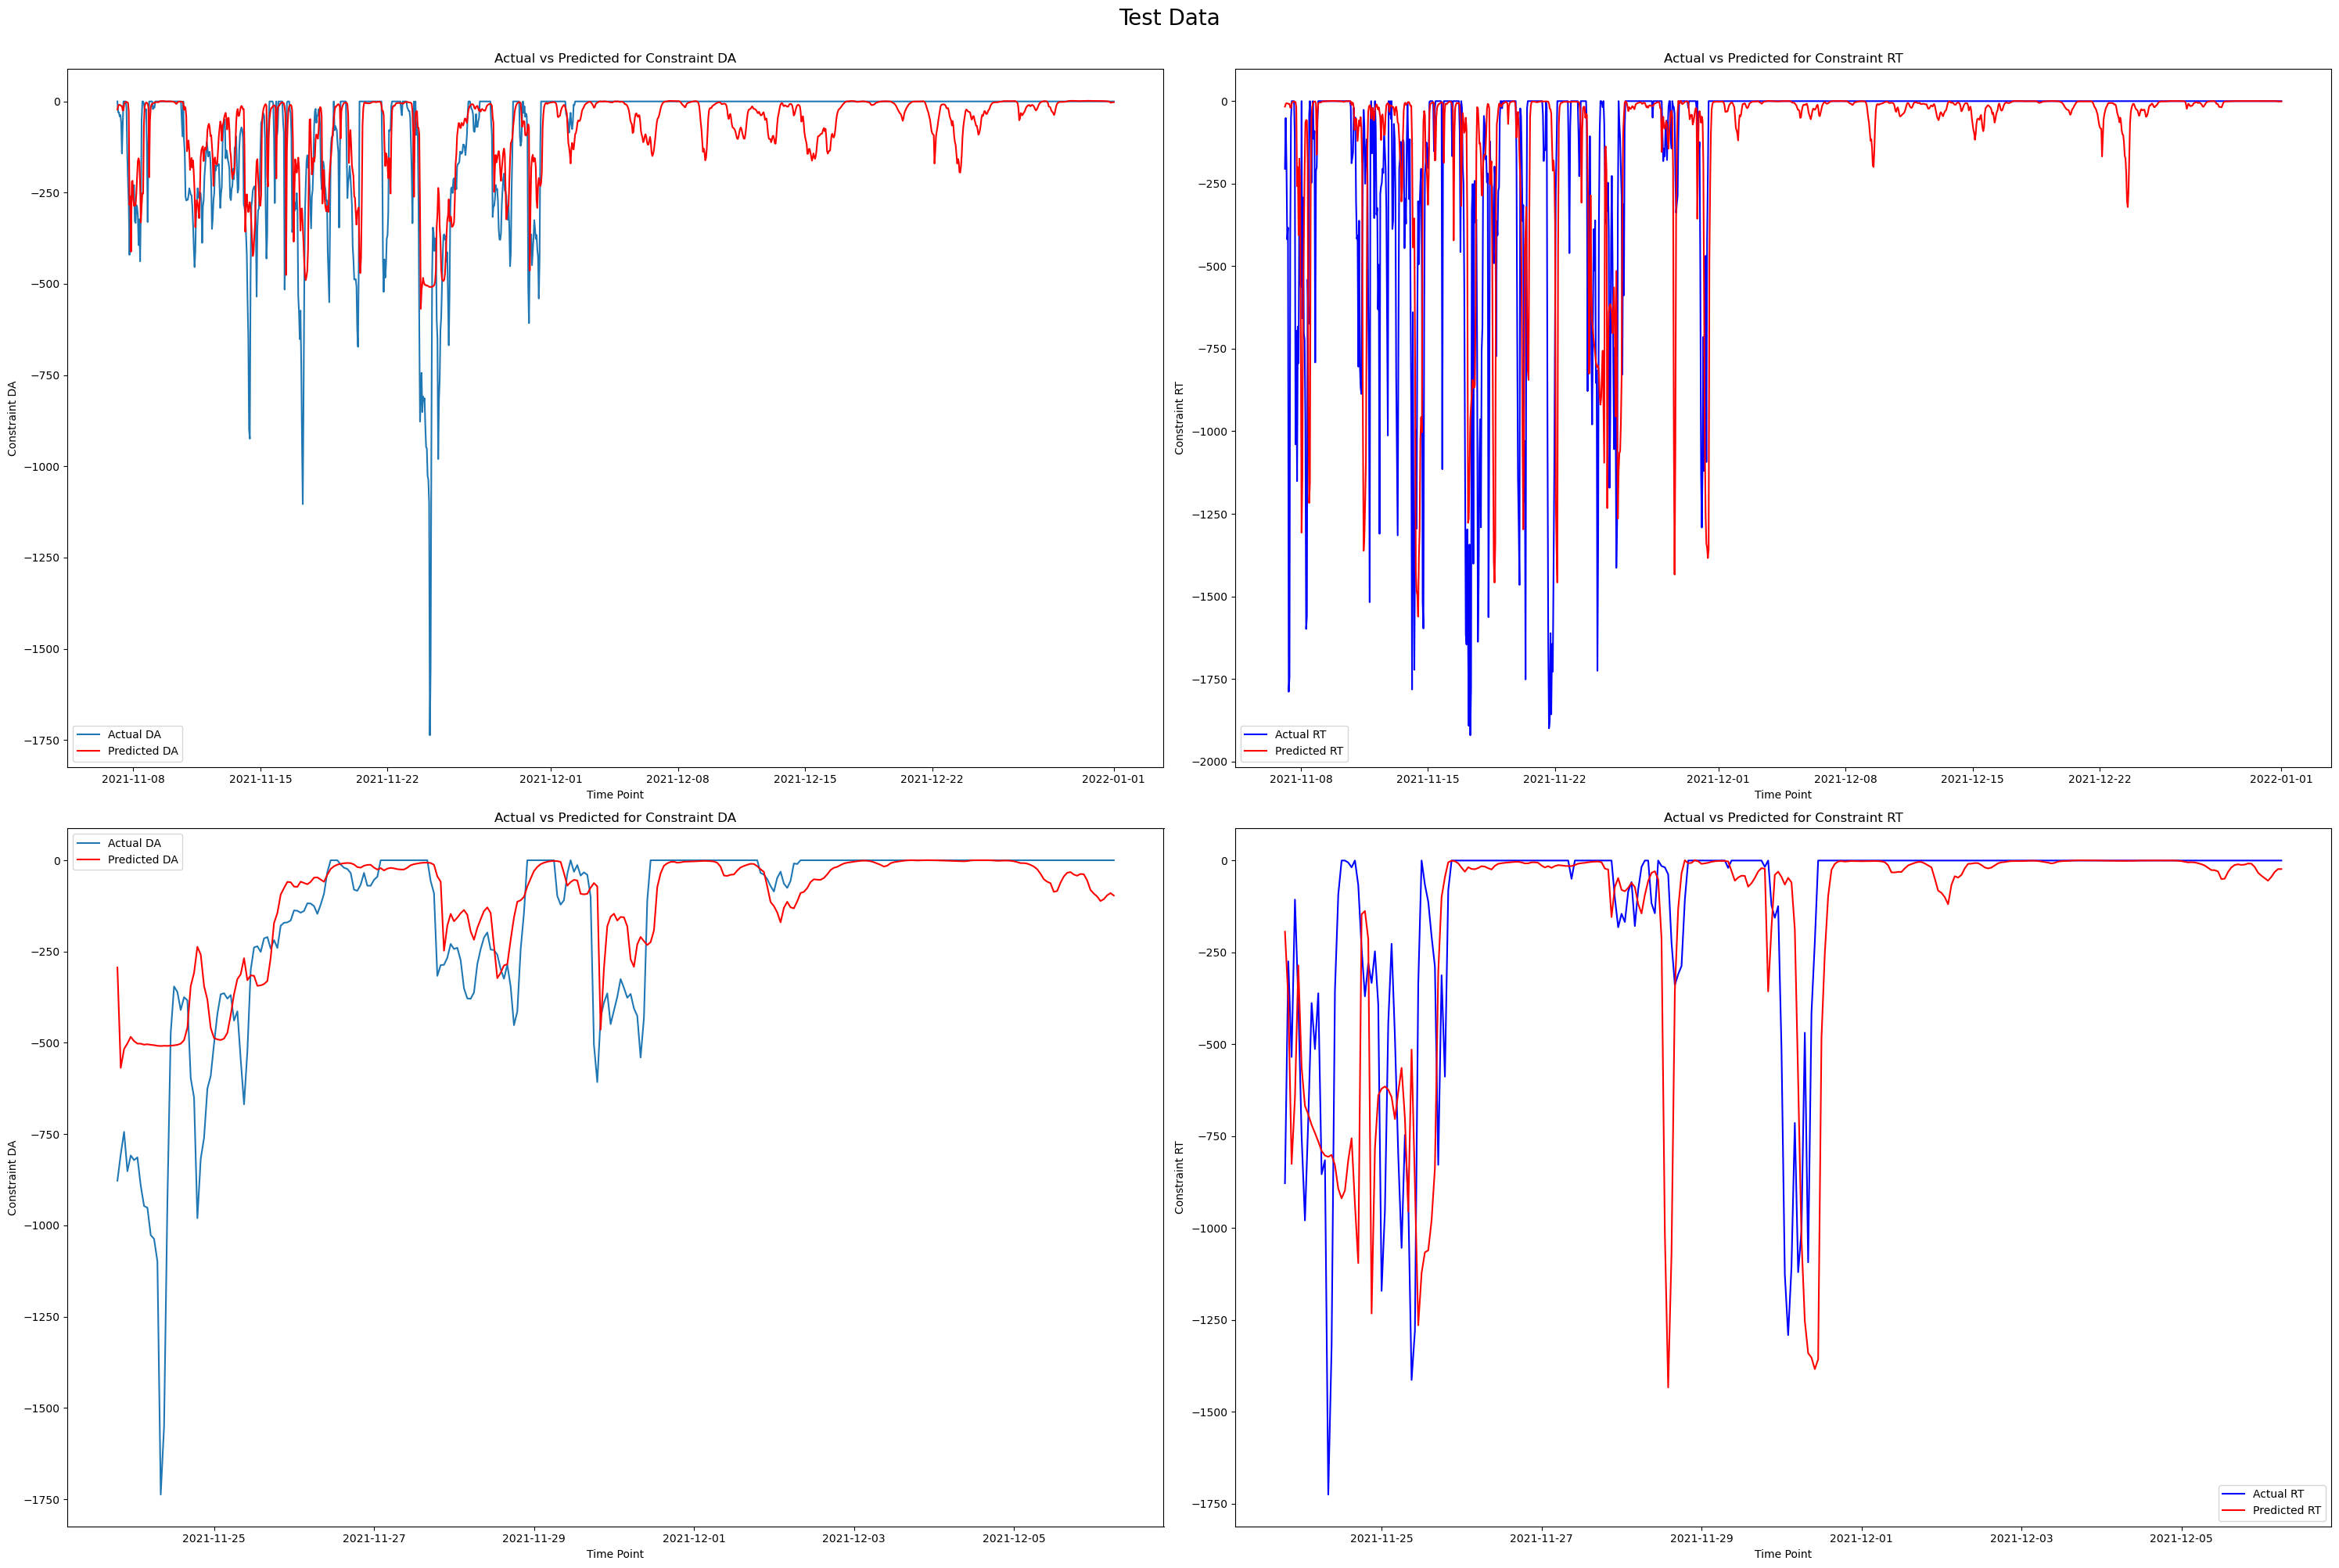

In [29]:
time_point = prediction_df.index.tolist()

start_index = 400  # Adjust this to change the starting index of the plot
end_index = 700  # Adjust this to change the ending index of the plot

fig, axs = plt.subplots(2, 2, figsize=(30, 20))

# Plot 1: Actual vs Predicted for Constraint DA (full range)
axs[0, 0].plot(time_point, y_test[:, 0], label='Actual DA')
axs[0, 0].plot(time_point, testPredict[:, 0], label='Predicted DA', color='red')
axs[0, 0].set_title('Actual vs Predicted for Constraint DA')
axs[0, 0].set_xlabel('Time Point')
axs[0, 0].set_ylabel('Constraint DA')
axs[0, 0].legend()

# Plot 2: Actual vs Predicted for Constraint RT (full range)
axs[0, 1].plot(time_point, y_test[:, 1], label='Actual RT', color = 'blue')
axs[0, 1].plot(time_point, testPredict[:, 1], label='Predicted RT', color='red')
axs[0, 1].set_title('Actual vs Predicted for Constraint RT')
axs[0, 1].set_xlabel('Time Point')
axs[0, 1].set_ylabel('Constraint RT')
axs[0, 1].legend()

# Plot 3: Actual vs Predicted for Constraint DA 
axs[1, 0].plot(time_point[start_index:end_index], y_test[start_index:end_index, 0], label='Actual DA')
axs[1, 0].plot(time_point[start_index:end_index], testPredict[start_index:end_index, 0], label='Predicted DA', color='red')
axs[1, 0].set_title('Actual vs Predicted for Constraint DA')
axs[1, 0].set_xlabel('Time Point')
axs[1, 0].set_ylabel('Constraint DA')
axs[1, 0].legend()

# Plot 4: Actual vs Predicted for Constraint RT
axs[1, 1].plot(time_point[start_index:end_index], y_test[start_index:end_index, 1], label='Actual RT', color="blue")
axs[1, 1].plot(time_point[start_index:end_index], testPredict[start_index:end_index, 1], label='Predicted RT', color='red')
axs[1, 1].set_title('Actual vs Predicted for Constraint RT')
axs[1, 1].set_xlabel('Time Point')
axs[1, 1].set_ylabel('Constraint RT')
axs[1, 1].legend()

fig.suptitle('Test Data', fontsize=20, y=1)
plt.tight_layout()
plt.show()

- The results were interesting. I noticed that it is relativley fitting the test data ok but it could be better given more data. But I also noticed small amounts of leakage in the training and test data and sometimes the prediction goes above 0. There may be some rework in my preproccessing.

### Hyperparamter optimzation (LSTM)

- Given the performance of the LSTM model, I decided to optimize the model by performing a Random Search for the Hyperparameters.

In [54]:
# Shift data
df['Prev_Day_Constraint_DA'] = df['Constraint DA'].shift(1)
df['Prev_Day_Constraint_RT'] = df['Constraint RT'].shift(1)

df = df.fillna(0)

input_features = df[['Wind', 'Solar', 'AEP Load', 'ATSI Load', 'COMED Load', 'DOM Load', 'Prev_Day_Constraint_DA', 'Prev_Day_Constraint_RT']]
output_features = df[['Constraint DA', 'Constraint RT']]

# Split into train and test sets (70/30 split)
train_size = int(len(df) * 0.7)
test_size = len(df) - train_size

# Train/Test split
input_features_train, input_features_test = input_features.iloc[:train_size], input_features.iloc[train_size:]
output_features_train, output_features_test = output_features.iloc[:train_size], output_features.iloc[train_size:]

input_scaler = MinMaxScaler(feature_range=(0, 1))
output_scaler = MinMaxScaler(feature_range=(0, 1))

scaled_input_train = input_scaler.fit_transform(input_features_train)
scaled_output_train = output_scaler.fit_transform(output_features_train)

scaled_input_test = input_scaler.transform(input_features_test)
scaled_output_test = output_scaler.transform(output_features_test)

train = np.concatenate((scaled_output_train, scaled_input_train), axis=1)
test = np.concatenate((scaled_output_test, scaled_input_test), axis=1)

look_back = 7
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], look_back, X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, X_test.shape[2]))


def tuned_model(HP_Tuner):
    model = Sequential()
    model.add(LSTM(HP_Tuner.Int('input_units', min_value=8, max_value=20, step=2), return_sequences=True, input_shape=(X_train.shape[1], 8)))
    model.add(Dense(units=HP_Tuner.Int('dense_units_1', min_value=30, max_value=70, step=10)))
    model.add(Dropout(HP_Tuner.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(LSTM(units=HP_Tuner.Int('lstm_units_1', min_value=30, max_value=70, step=10), return_sequences=True))
    model.add(Dense(units=HP_Tuner.Int('dense_units_2', min_value=30, max_value=70, step=10)))
    model.add(Dropout(HP_Tuner.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(LSTM(units=HP_Tuner.Int('lstm_units_2', min_value=30, max_value=70, step=10), return_sequences=True))
    model.add(Dense(units=HP_Tuner.Int('dense_units_3', min_value=30, max_value=70, step=10)))
    model.add(Dropout(HP_Tuner.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(LSTM(units=HP_Tuner.Int('lstm_units_3', min_value=30, max_value=70, step=10)))
    model.add(Dense(units=2))
    
    model.compile(loss='mean_squared_error', optimizer=Adam(HP_Tuner.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])))
    
    return model


tuner = RandomSearch(
    tuned_model,
    objective='val_loss',
    max_trials=6,
    executions_per_trial=4,
    directory='V5',
    project_name='DA_RT')

tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))


Trial 6 Complete [00h 01m 22s]
val_loss: 0.03673178795725107

Best val_loss So Far: 0.03617086075246334
Total elapsed time: 00h 08m 48s
INFO:tensorflow:Oracle triggered exit


In [55]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
bm = best_model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)

Epoch 1/100
193/193 [==============================] - 12s 27ms/step - loss: 0.0047
Epoch 2/100
193/193 [==============================] - 5s 26ms/step - loss: 0.0042
Epoch 3/100
193/193 [==============================] - 5s 26ms/step - loss: 0.0041
Epoch 4/100
193/193 [==============================] - 5s 27ms/step - loss: 0.0041
Epoch 5/100
193/193 [==============================] - 5s 26ms/step - loss: 0.0039
Epoch 6/100
193/193 [==============================] - 5s 25ms/step - loss: 0.0039
Epoch 7/100
193/193 [==============================] - 5s 26ms/step - loss: 0.0037
Epoch 8/100
193/193 [==============================] - 5s 26ms/step - loss: 0.0036
Epoch 9/100
193/193 [==============================] - 5s 26ms/step - loss: 0.0036
Epoch 10/100
193/193 [==============================] - 5s 26ms/step - loss: 0.0035
Epoch 11/100
193/193 [==============================] - 5s 26ms/step - loss: 0.0031
Epoch 12/100
193/193 [==============================] - 5s 27ms/step - loss: 0.0029


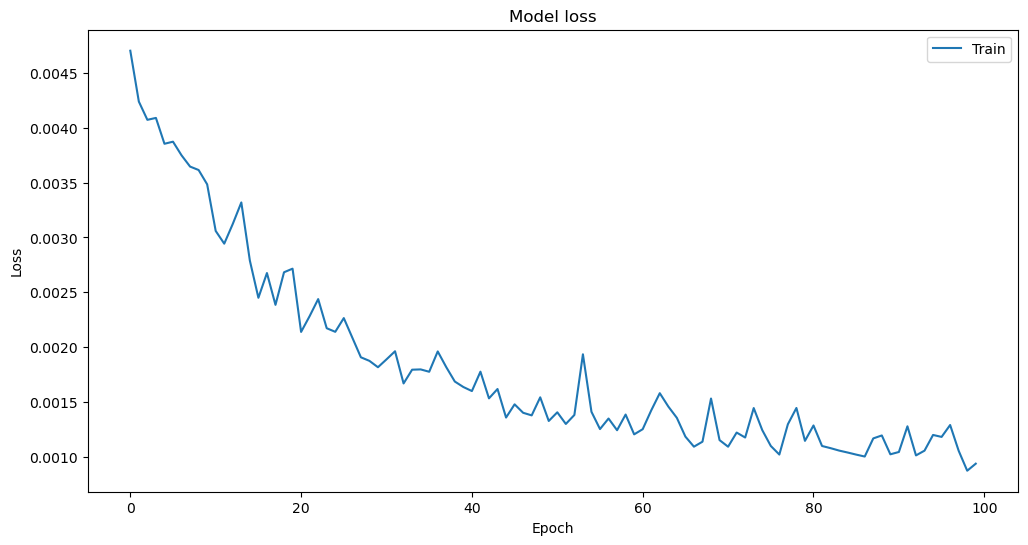

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(bm.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()


In [57]:
# Make predictions with the best model
bm_trainPredict = best_model.predict(X_train)
bm_testPredict = best_model.predict(X_test)

bm_trainPredict = output_scaler.inverse_transform(bm_trainPredict)
y_train = output_scaler.inverse_transform(y_train)
bm_testPredict = output_scaler.inverse_transform(bm_testPredict)
y_test = output_scaler.inverse_transform(y_test)

# For Constraint DA
print("DA")
DA_y_true = y_test[:, 0]
DA_y_pred = bm_testPredict[:, 0]

# RMSE
DA_rmse = np.sqrt(mean_squared_error(DA_y_true, DA_y_pred))
DA_mae = mean_absolute_error(DA_y_true, DA_y_pred)
DA_r2 = r2_score(DA_y_true, DA_y_pred)
DA_dir_acc = np.mean(np.sign(DA_y_true[1:] - DA_y_true[:-1]) == np.sign(DA_y_pred[1:] - DA_y_pred[:-1]))

print(f'Root Mean Squared Error: {DA_rmse}')
print(f'Mean Absolute Error: {DA_mae}')
print(f'R2 Score: {DA_r2}')
print(f'Direction Accuracy: {DA_dir_acc}')

print("---------------------------------------------")

# For Constraint RT
print("RT")
RT_y_true = y_test[:, 1]
RT_y_pred = bm_testPredict[:, 1]

RT_rmse = np.sqrt(mean_squared_error(RT_y_true, RT_y_pred))
RT_mae = mean_absolute_error(RT_y_true, RT_y_pred)
RT_r2 = r2_score(RT_y_true, RT_y_pred)
RT_dir_acc = np.mean(np.sign(RT_y_true[1:] - RT_y_true[:-1]) == np.sign(RT_y_pred[1:] - RT_y_pred[:-1]))

print(f'Root Mean Squared Error: {RT_rmse}')
print(f'Mean Absolute Error: {RT_mae}')
print(f'R2 Score: {RT_r2}')
print(f'Direction Accuracy: {RT_dir_acc}')

42/42 [==============================] - 1s 12ms/step
DA
Root Mean Squared Error: 131.42302095517516
Mean Absolute Error: 73.19537890385062
R2 Score: 0.48672768929566124
Direction Accuracy: 0.1829916476841306
---------------------------------------------
RT
Root Mean Squared Error: 314.73804433081057
Mean Absolute Error: 127.71701510209313
R2 Score: 0.12759089544032454
Direction Accuracy: 0.1275626423690205


In [58]:
look_back = 7

predictions = bm_trainPredict
prediction_df = pd.DataFrame(predictions, columns=['Predicted DA', 'Predicted RT'])

date_time = df['Date/Time']
test_size = int(len(df) * 0.3)

total_look_back = (look_back-3) * 2 + 1
adjusted_df_index = date_time[test_size + total_look_back:]

prediction_df = prediction_df.set_index(adjusted_df_index)
prediction_df


Predicted DA  Predicted RT
Date/Time                                      
2021-08-25 15:00:00     -4.142542      9.188160
2021-08-25 16:00:00     -3.774819      9.213655
2021-08-25 17:00:00     -3.733190      9.396633
2021-08-25 18:00:00     -3.961967      9.368656
2021-08-25 19:00:00     -4.288882      9.249754
...                           ...           ...
2021-12-31 20:00:00    -20.773327    -12.045076
2021-12-31 21:00:00    -17.903208    -12.597733
2021-12-31 22:00:00    -13.523765     -1.624466
2021-12-31 23:00:00    -11.565285      6.668658
2022-01-01 00:00:00    -15.044593      8.950130

[3083 rows x 2 columns]

- There appears to be a strange occurance of positive values, not sure why this happened but it could be from the data leakage in the preproccessing I mention earlier.

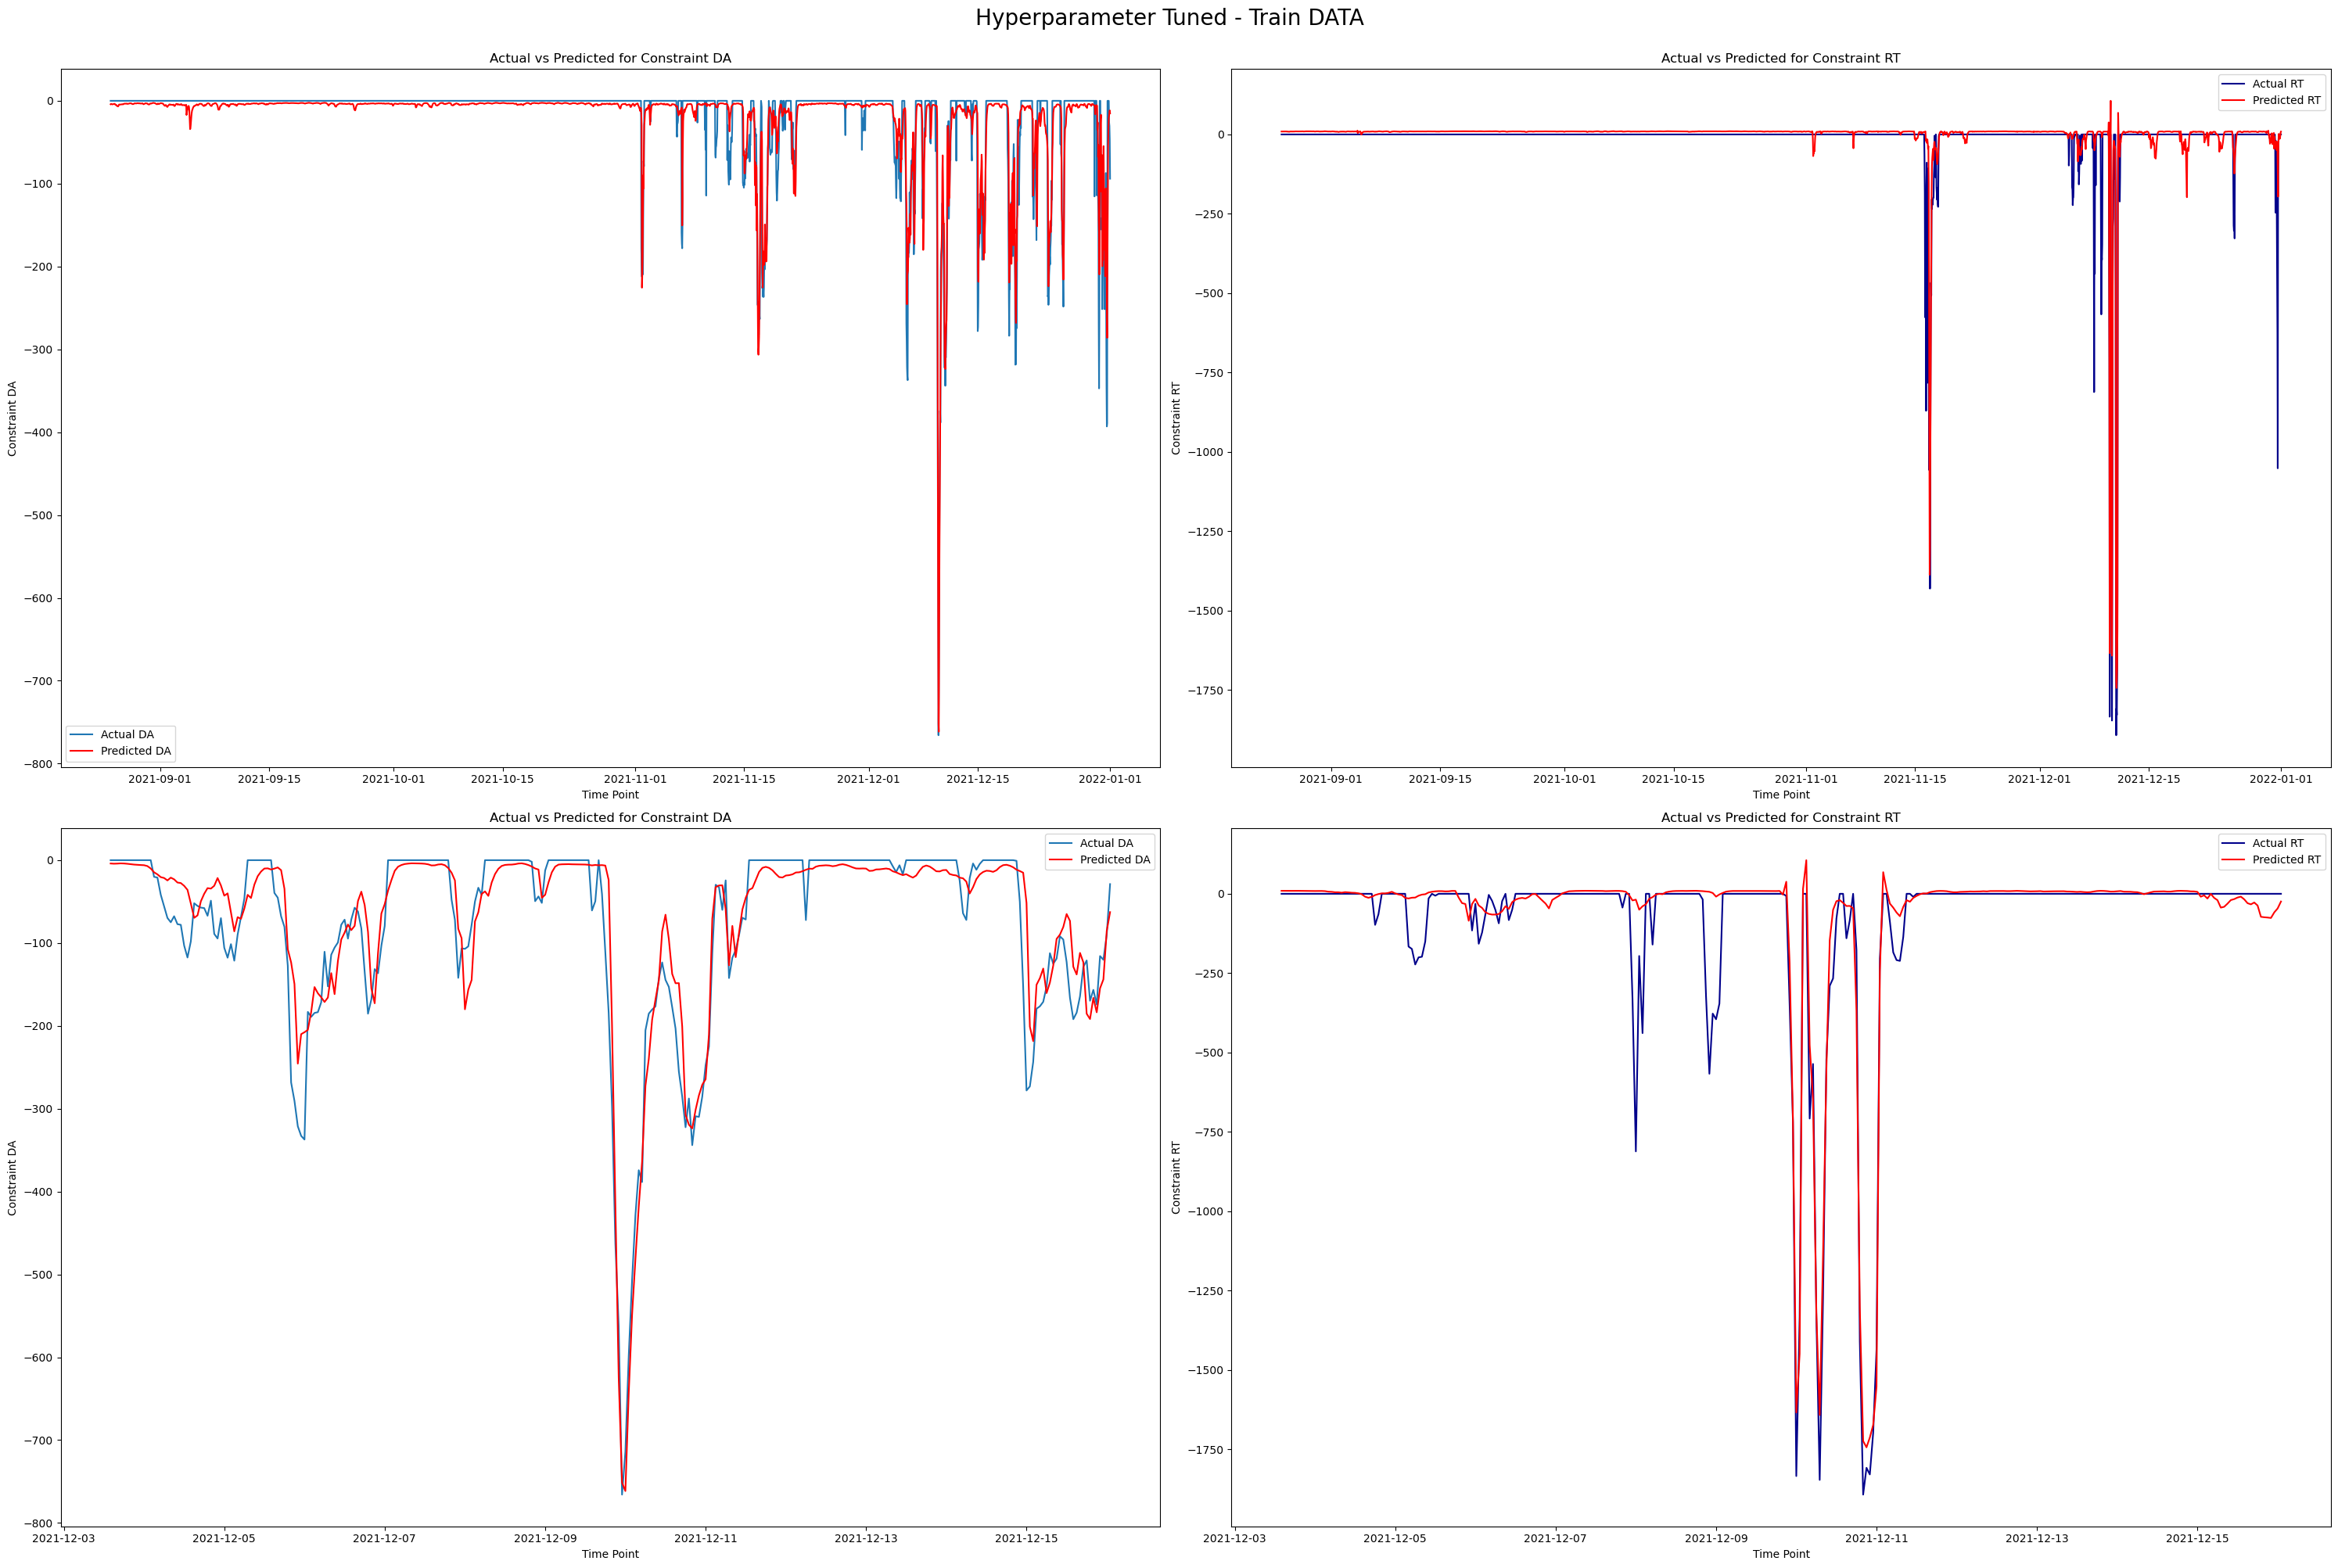

In [59]:
time_point = prediction_df.index.tolist()

start_index = 2400  # Adjust this to change the starting index of the plot
end_index = 2700  # Adjust this to change the ending index of the plot

fig, axs = plt.subplots(2, 2, figsize=(30, 20))

# Plot 1: Actual vs Predicted for Constraint DA (full range)
axs[0, 0].plot(time_point, y_train[:, 0], label='Actual DA')
axs[0, 0].plot(time_point, bm_trainPredict[:, 0], label='Predicted DA', color='red')
axs[0, 0].set_title('Actual vs Predicted for Constraint DA')
axs[0, 0].set_xlabel('Time Point')
axs[0, 0].set_ylabel('Constraint DA')
axs[0, 0].legend()

# Plot 2: Actual vs Predicted for Constraint RT (full range)
axs[0, 1].plot(time_point, y_train[:, 1], label='Actual RT', color = 'darkblue')
axs[0, 1].plot(time_point, bm_trainPredict[:, 1], label='Predicted RT', color='red')
axs[0, 1].set_title('Actual vs Predicted for Constraint RT')
axs[0, 1].set_xlabel('Time Point')
axs[0, 1].set_ylabel('Constraint RT')
axs[0, 1].legend()

# Plot 3: Actual vs Predicted for Constraint DA 
axs[1, 0].plot(time_point[start_index:end_index], y_train[start_index:end_index, 0], label='Actual DA')
axs[1, 0].plot(time_point[start_index:end_index], bm_trainPredict[start_index:end_index, 0], label='Predicted DA', color='red')
axs[1, 0].set_title('Actual vs Predicted for Constraint DA')
axs[1, 0].set_xlabel('Time Point')
axs[1, 0].set_ylabel('Constraint DA')
axs[1, 0].legend()

# Plot 4: Actual vs Predicted for Constraint RT
axs[1, 1].plot(time_point[start_index:end_index], y_train[start_index:end_index, 1], label='Actual RT', color="darkblue")
axs[1, 1].plot(time_point[start_index:end_index], bm_trainPredict[start_index:end_index, 1], label='Predicted RT', color='red')
axs[1, 1].set_title('Actual vs Predicted for Constraint RT')
axs[1, 1].set_xlabel('Time Point')
axs[1, 1].set_ylabel('Constraint RT')
axs[1, 1].legend()

fig.suptitle('Hyperparameter Tuned - Train DATA', fontsize=20, y=1)
plt.tight_layout()
plt.show()

In [60]:
look_back = 7

predictions = bm_testPredict
prediction_df = pd.DataFrame(
    predictions, columns=['Predicted DA', 'Predicted RT'])

date_time = df['Date/Time']
train_size = int(len(df) * 0.7)

total_look_back = (look_back-3) * 2
adjusted_df_index = date_time[train_size + total_look_back:]

prediction_df = prediction_df.set_index(adjusted_df_index)
prediction_df


Predicted DA  Predicted RT
Date/Time                                      
2021-11-07 03:00:00    -35.635063      2.557180
2021-11-07 04:00:00    -20.930988      0.646628
2021-11-07 05:00:00    -14.256928      5.949606
2021-11-07 06:00:00    -15.232927      7.344842
2021-11-07 07:00:00    -16.238779      7.501874
...                           ...           ...
2021-12-31 20:00:00    -10.855218      7.528272
2021-12-31 21:00:00     -8.094741      7.338299
2021-12-31 22:00:00     -7.117189      8.389915
2021-12-31 23:00:00     -6.619650      8.514458
2022-01-01 00:00:00     -6.127953      8.657501

[1318 rows x 2 columns]

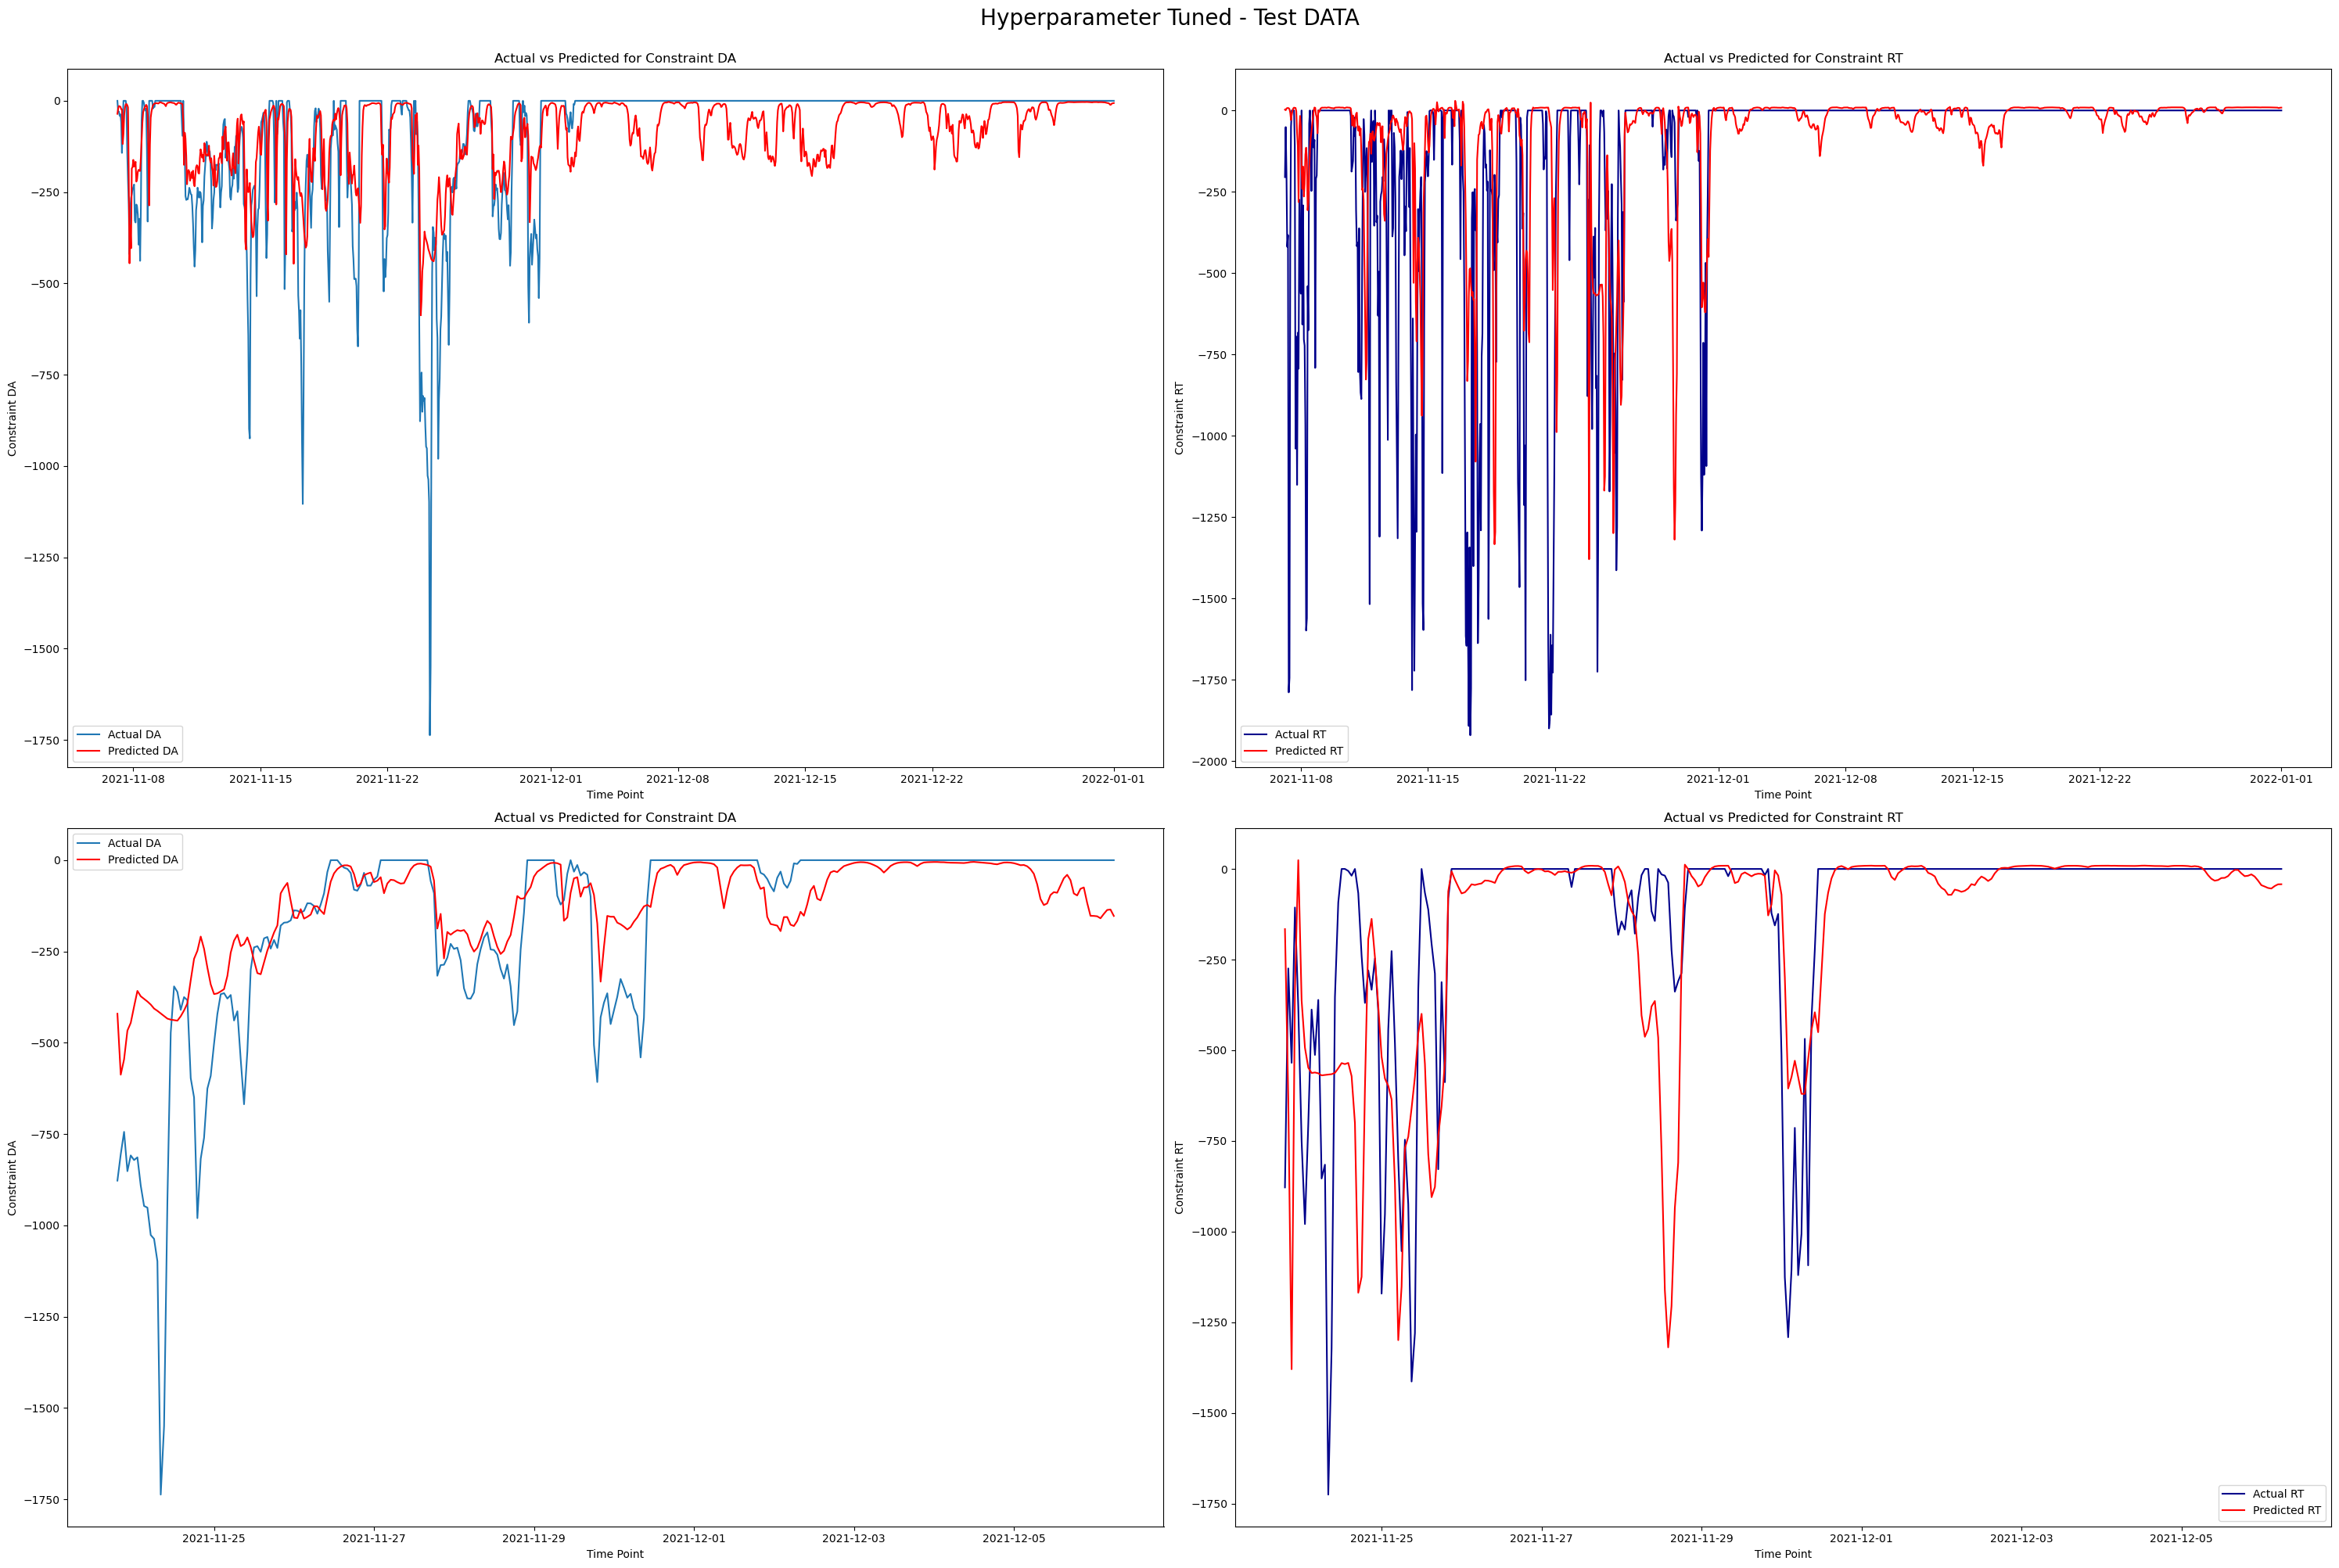

In [61]:
time_point = prediction_df.index.tolist()

start_index = 400  # Adjust this to change the starting index of the plot
end_index = 700  # Adjust this to change the ending index of the plot

fig, axs = plt.subplots(2, 2, figsize=(30, 20))

# Plot 1: Actual vs Predicted for Constraint DA (full range)
axs[0, 0].plot(time_point, y_test[:, 0], label='Actual DA')
axs[0, 0].plot(time_point, bm_testPredict[:, 0], label='Predicted DA', color='red')
axs[0, 0].set_title('Actual vs Predicted for Constraint DA')
axs[0, 0].set_xlabel('Time Point')
axs[0, 0].set_ylabel('Constraint DA')
axs[0, 0].legend()

# Plot 2: Actual vs Predicted for Constraint RT (full range)
axs[0, 1].plot(time_point, y_test[:, 1], label='Actual RT', color = 'darkblue')
axs[0, 1].plot(time_point, bm_testPredict[:, 1], label='Predicted RT', color='red')
axs[0, 1].set_title('Actual vs Predicted for Constraint RT')
axs[0, 1].set_xlabel('Time Point')
axs[0, 1].set_ylabel('Constraint RT')
axs[0, 1].legend()

# Plot 3: Actual vs Predicted for Constraint DA 
axs[1, 0].plot(time_point[start_index:end_index], y_test[start_index:end_index, 0], label='Actual DA')
axs[1, 0].plot(time_point[start_index:end_index], bm_testPredict[start_index:end_index, 0], label='Predicted DA', color='red')
axs[1, 0].set_title('Actual vs Predicted for Constraint DA')
axs[1, 0].set_xlabel('Time Point')
axs[1, 0].set_ylabel('Constraint DA')
axs[1, 0].legend()

# Plot 4: Actual vs Predicted for Constraint RT
axs[1, 1].plot(time_point[start_index:end_index], y_test[start_index:end_index, 1], label='Actual RT', color="darkblue")
axs[1, 1].plot(time_point[start_index:end_index], bm_testPredict[start_index:end_index, 1], label='Predicted RT', color='red')
axs[1, 1].set_title('Actual vs Predicted for Constraint RT')
axs[1, 1].set_xlabel('Time Point')
axs[1, 1].set_ylabel('Constraint RT')
axs[1, 1].legend()

fig.suptitle('Hyperparameter Tuned - Test DATA', fontsize=20, y=1)
plt.tight_layout()
plt.show()

- Final review: given the performance on the test data, another approach can be conducted. The LSTM was a good intial test and gave me some ideas of possibly implementing other ML models that could be more sutiable.   

## Linear Regression

- I was curious about how the standard linear regression model would do, given that DA and RT have somewhat of a linear relationship 

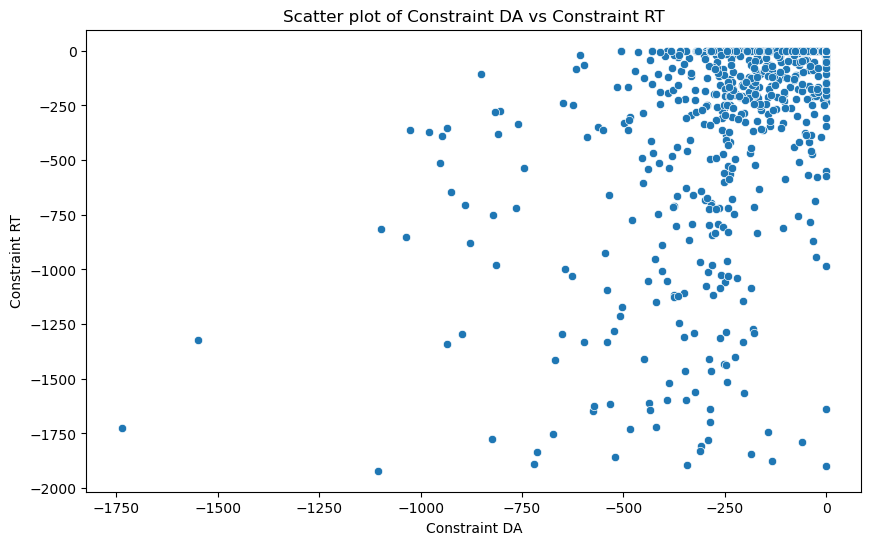

Pearson correlation coefficient: 0.638


In [38]:
plt.figure(figsize=(10, 6))
sms.scatterplot(data=df, x='Constraint DA', y='Constraint RT')
plt.title('Scatter plot of Constraint DA vs Constraint RT')
plt.show()

correlation, _ = pearsonr(df['Constraint DA'], df['Constraint RT'])
print('Pearson correlation coefficient: %.3f' % correlation)


A correlation coefficient of 0.638 suggest a moderate postive linear relationship, but it's not a very strong one. So, as one variable increases, the other tends to increase as well, but not perfectly. However, correlation does not imply causation. Even if two variables have a strong linear relationship, it does not mean that changes in one variable are causing changes in the other. It just means they tend to move together (Relatively).

In [39]:
X = df[['Wind', 'Solar', 'AEP Load', 'ATSI Load', 'COMED Load',
        'DOM Load', 'Prev_Day_Constraint_DA', 'Prev_Day_Constraint_RT']]
y_DA = df['Constraint DA']
y_RT = df['Constraint RT']

# Define the train size (70/30 split)
train_size = int(len(df) * 0.7) 

# Split the data
X_train_DA, X_test_DA = X[:train_size], X[train_size:]
y_train_DA, y_test_DA = y_DA[:train_size], y_DA[train_size:]

X_train_RT, X_test_RT = X[:train_size], X[train_size:]
y_train_RT, y_test_RT = y_RT[:train_size], y_RT[train_size:]



model = LinearRegression()

model.fit(X_train_DA, y_train_DA)
y_pred_train_DA = model.predict(X_train_DA)
y_pred_test_DA = model.predict(X_test_DA)

model.fit(X_train_RT, y_train_RT)
y_pred_train_RT = model.predict(X_train_RT)
y_pred_test_RT = model.predict(X_test_RT)


In [40]:
# For Constraint DA
print("DA")

DA_rmse = np.sqrt(mean_squared_error(y_test_DA, y_pred_test_DA))
DA_mae = mean_absolute_error(y_test_DA, y_pred_test_DA)
DA_r2 = r2_score(y_test_DA, y_pred_test_DA)
print(f'Root Mean Squared Error: {DA_rmse}')
print(f'Mean Absolute Error: {DA_mae}')
print(f'R2 Score: {DA_r2}')

print("---------------------------------------------")

# For Constraint RT
print("RT")

RT_rmse = np.sqrt(mean_squared_error(y_test_RT, y_pred_test_RT))
RT_mae = mean_absolute_error(y_test_RT, y_pred_test_RT)
RT_r2 = r2_score(y_test_RT, y_pred_test_RT)
print(f'Root Mean Squared Error: {RT_rmse}')
print(f'Mean Absolute Error: {RT_mae}')
print(f'R2 Score: {RT_r2}')


DA
Root Mean Squared Error: 61.72622761302512
Mean Absolute Error: 26.63034381728205
R2 Score: 0.8862313364355504
---------------------------------------------
RT
Root Mean Squared Error: 199.47397342654628
Mean Absolute Error: 78.19656494820825
R2 Score: 0.6500745197817901


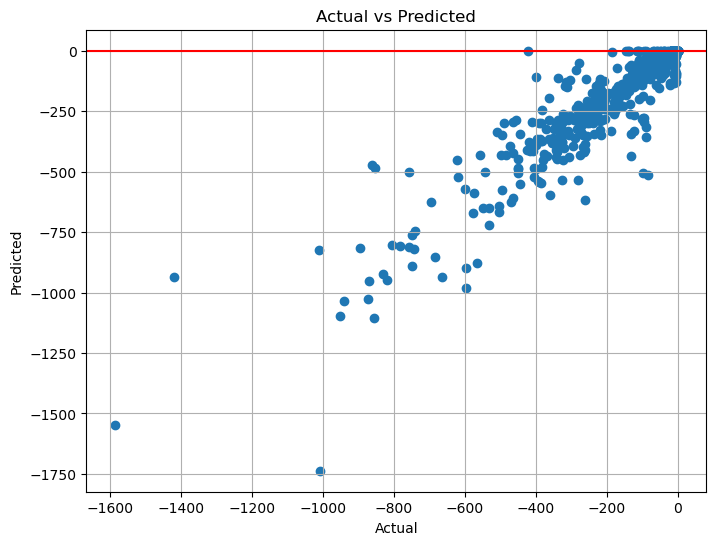

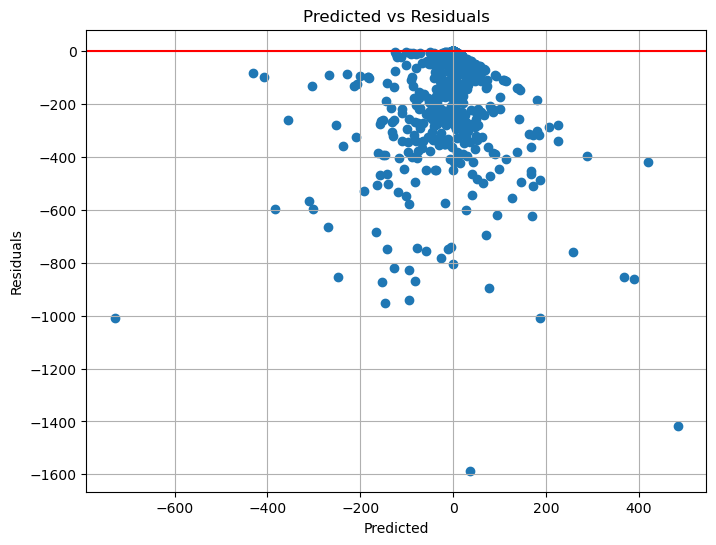

In [41]:
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_test_DA, y_test_DA)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

residuals = y_test_DA - y_pred_test_DA
plt.figure(figsize=(8, 6))
plt.scatter(residuals, y_pred_test_DA)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Predicted vs Residuals')
plt.grid(True)
plt.show()


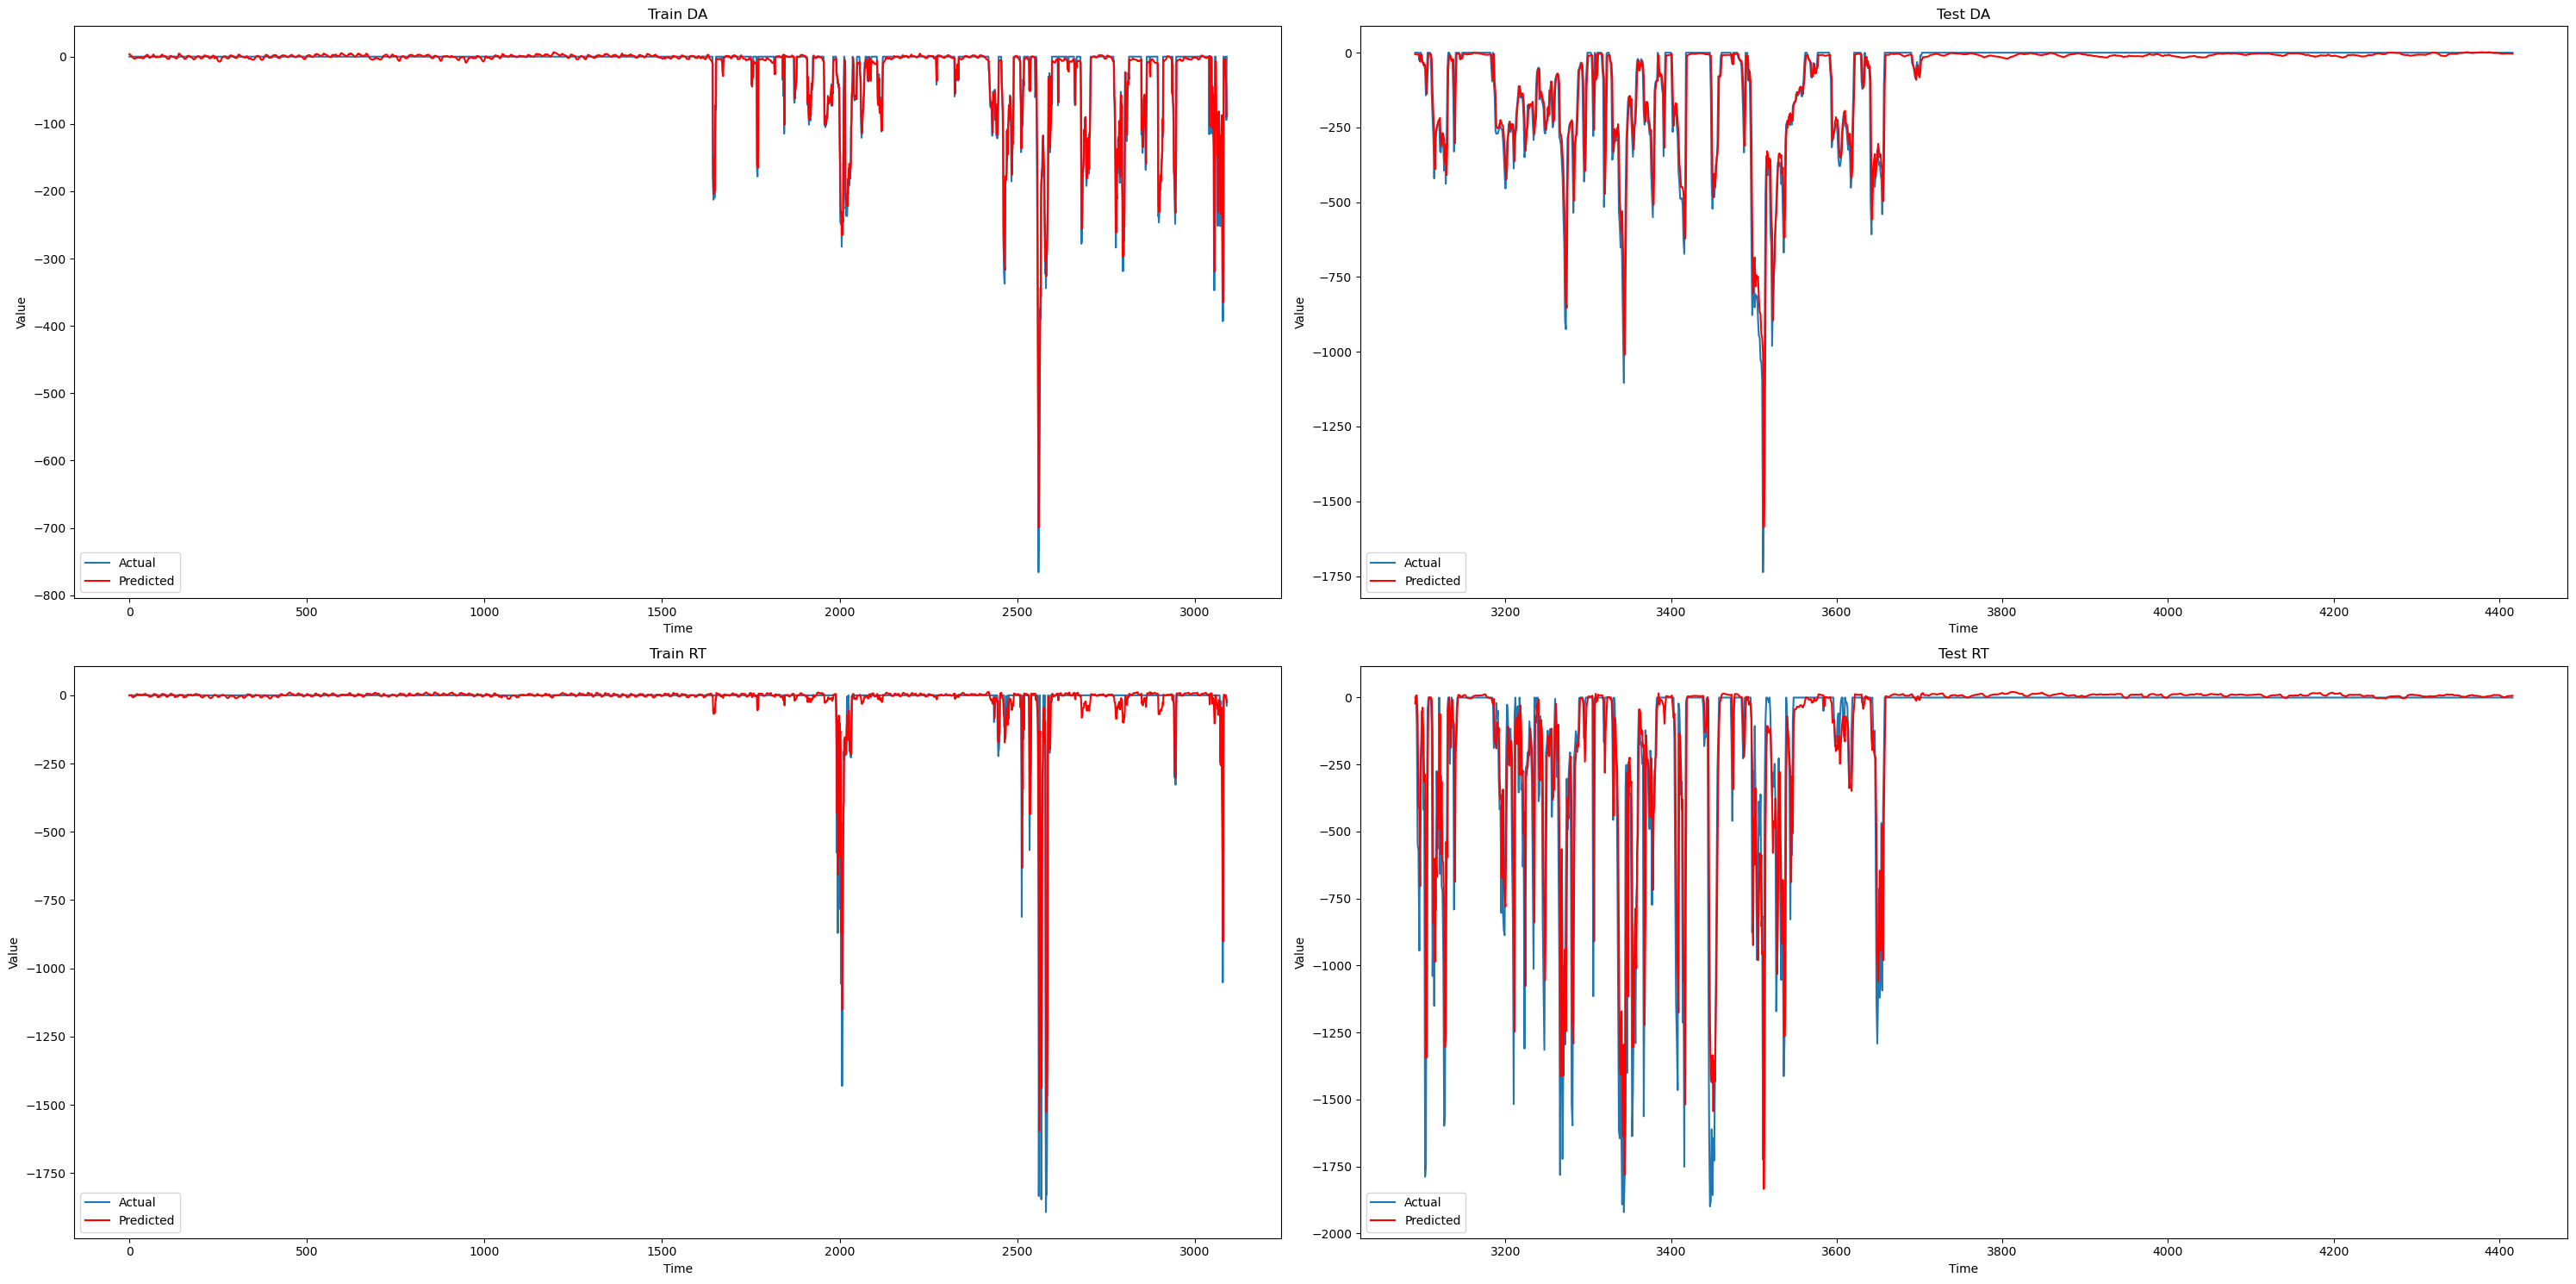

In [42]:
df_pred_train_DA = pd.DataFrame(y_pred_train_DA, index=y_train_DA.index, columns=['Prediction'])
df_pred_test_DA = pd.DataFrame(y_pred_test_DA, index=y_test_DA.index, columns=['Prediction'])

df_combined_train_DA = pd.concat([y_train_DA, df_pred_train_DA], axis=1)
df_combined_test_DA = pd.concat([y_test_DA, df_pred_test_DA], axis=1)

df_pred_train_RT = pd.DataFrame(y_pred_train_RT, index=y_train_RT.index, columns=['Prediction'])
df_pred_test_RT = pd.DataFrame(y_pred_test_RT, index=y_test_RT.index, columns=['Prediction'])

df_combined_train_RT = pd.concat([y_train_RT, df_pred_train_RT], axis=1)
df_combined_test_RT = pd.concat([y_test_RT, df_pred_test_RT], axis=1)

fig, axs = plt.subplots(2, 2, figsize=(30, 15))

# Train DA
axs[0, 0].plot(df_combined_train_DA.index, df_combined_train_DA['Constraint DA'], label='Actual')
axs[0, 0].plot(df_combined_train_DA.index, df_combined_train_DA['Prediction'], label='Predicted', color='red')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Value')
axs[0, 0].set_title("Train DA")
axs[0, 0].legend()

# Test DA
axs[0, 1].plot(df_combined_test_DA.index, df_combined_test_DA['Constraint DA'], label='Actual')
axs[0, 1].plot(df_combined_test_DA.index, df_combined_test_DA['Prediction'], label='Predicted', color='red')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Value')
axs[0, 1].set_title("Test DA")
axs[0, 1].legend()

# Train RT
axs[1, 0].plot(df_combined_train_RT.index, df_combined_train_RT['Constraint RT'], label='Actual')
axs[1, 0].plot(df_combined_train_RT.index, df_combined_train_RT['Prediction'], label='Predicted', color='red')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Value')
axs[1, 0].set_title("Train RT")
axs[1, 0].legend()

# Test RT
axs[1, 1].plot(df_combined_test_RT.index, df_combined_test_RT['Constraint RT'], label='Actual')
axs[1, 1].plot(df_combined_test_RT.index, df_combined_test_RT['Prediction'], label='Predicted', color='red')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Value')
axs[1, 1].set_title("Test RT")
axs[1, 1].legend()
plt.tight_layout()
plt.show()


- The linear regression model is performing quite well for predicting DA and RT Constraints. The Root Mean Square Error (RMSE) values indicate the average discrepancy between the model's predictions and the actual values, with smaller values implying better performance. For your model, the DA RMSE is 61.72, and the RT RMSE is 199.47, showing a reasonable level of accuracy.

- The R^2 scores (0.8862 for DA and 0.650 for RT) shows that the predictions are fitting relativley well, In our case, 88.62% of the variance in the DA Constraint and 0.65% of the variance in the RT Constraint can be explained by your model. This shhows strong predictive power, indicating the model could be reliable for predicting the DA and RT constraints. 

- However with all this said, I am concered about the model overfitting the data. Even though it performed well on the test data, it just appears to be strangly accurate given such a complicated behaviour with just a simple linear regression model

# Future Models

- The are some ideas that I thought of implementing. Would like to hear you input if these are worth pursing. And any suggestion is appreciated

## SARIMAX

In [43]:
# import statsmodels.api as sm

# model = sm.tsa.statespace.SARIMAX(df['Constraint DA'],
#                                   order=(1, 1, 1),
#                                   seasonal_order=(1, 1, 1, 12),
#                                   exog=df[['Wind', 'Solar', 'AEP Load', 'ATSI Load', 'COMED Load', 'DOM Load']])

# results = model.fit()

# # Get forecast 10 steps ahead in future
# pred_uc = results.get_forecast(steps=10, exog=df[['Wind', 'Solar', 'AEP Load', 'ATSI Load', 'COMED Load', 'DOM Load']])

# pred_ci = pred_uc.conf_int()


## ARIMA

In [44]:
from statsmodels.tsa.arima.model import ARIMA

In [45]:
DA_series = pd.Series(df['Constraint DA'].values, index=df['Date/Time'])

model = ARIMA(DA_series, order=(1, 1, 1))
model_fit = model.fit()

model_fit.summary()


c:\Users\William Hazen\anaconda3\envs\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\William Hazen\anaconda3\envs\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\William Hazen\anaconda3\envs\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\William Hazen\anaconda3\envs\venv\lib\site-packages\statsmodels\tsa\stattools.py:1346: RuntimeWarning: divide by zero encountered in divide
  test_statistic = numer_squared_sum /

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4417
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -22199.414
Date:                Tue, 18 Jul 2023   AIC                          44404.827
Time:                        15:10:55   BIC                          44424.006
Sample:                             0   HQIC                         44411.591
                               - 4417                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0030      0.012      0.244      0.807      -0.021       0.027
ma.L1          0.2853      0.012     24.202      0.000       0.262       0.308
sigma2      1361.2672      5.537    245.851      0.000    1350.415    1372.119
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            661950.43
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):                inf   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        62.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

c:\Users\William Hazen\anaconda3\envs\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<Axes: >

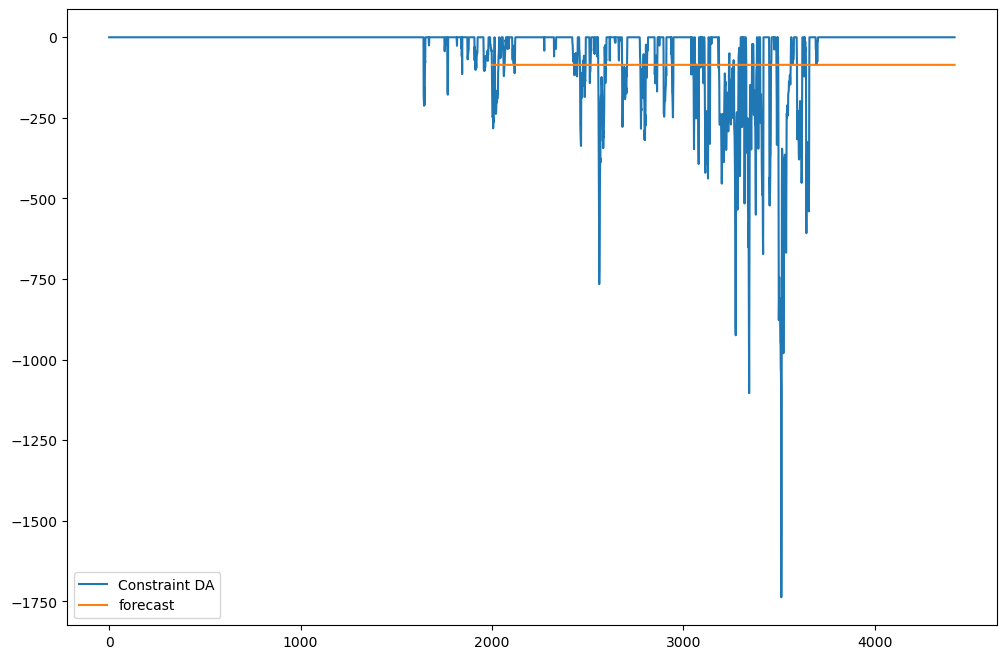

In [46]:
df['forecast']=model_fit.predict(start=2000,end=5000,dynamic=True)
df[['Constraint DA','forecast']].plot(figsize=(12,8))

In [47]:
model=sm.tsa.statespace.SARIMAX(df['Constraint DA'],order=(1, 1, 1),seasonal_order=(1,1,1, 12))
results=model.fit()

<Axes: >

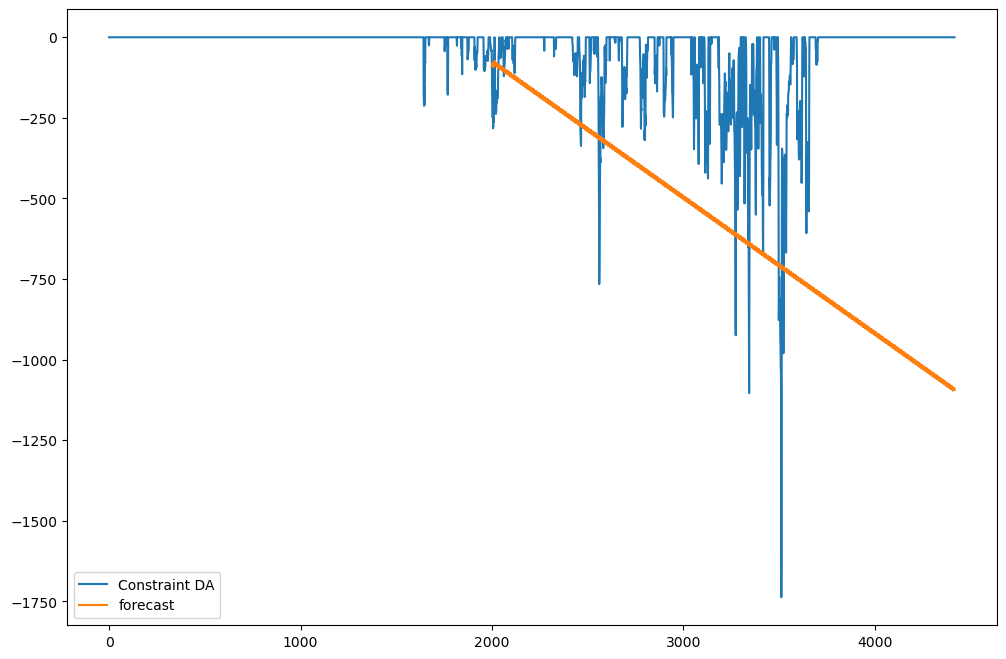

In [48]:
df['forecast']=results.predict(start=2000,end=4500,dynamic=True)
df[['Constraint DA','forecast']].plot(figsize=(12,8))

## AR Model

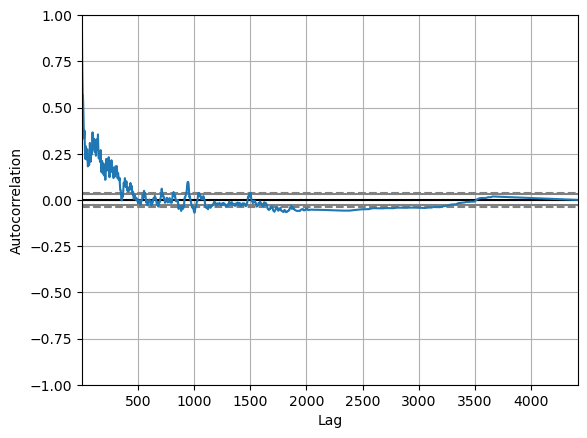

In [49]:
pd.plotting.autocorrelation_plot(df['Constraint DA'])
plt.show()


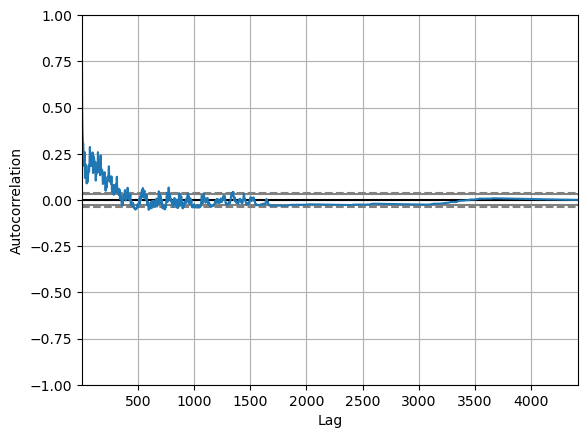

In [50]:
pd.plotting.autocorrelation_plot(df['Constraint RT'])
plt.show()


## Final Thoughts on Autocorrelation and Partial Autocorrelation

https://github.com/krishnaik06/ARIMA-And-Seasonal-ARIMA/blob/master/Untitled.ipynb

- Identification of an AR model is often best done with the PACF.

    - For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.

- Identification of an MA model is often best done with the ACF rather than the PACF.

    - For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.
    
p,d,q p AR model lags d differencing q MA lags

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


c:\Users\William Hazen\anaconda3\envs\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


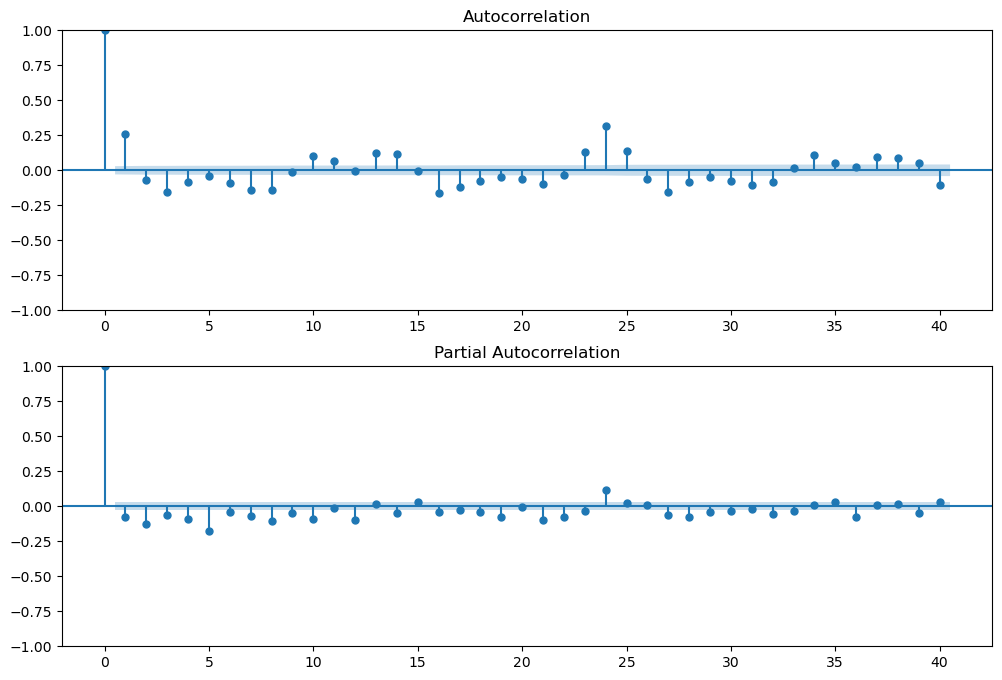

In [52]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['DA Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['RT Difference'].iloc[13:],lags=40,ax=ax2)